In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from sklearn import preprocessing

import pymc3 as pm
import theano.tensor as tt

from matplotlib import pylab as plt
import seaborn as sns

plt.style.use("bmh")

import arviz as az

%load_ext watermark
%matplotlib inline

In [2]:
%watermark -v -d -t -z -u -r -iv

Last updated: 2022-01-08 16:42:19PST

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 7.30.1

Git repo: git@github.com:clausherther/nfl-analysis.git

scipy     : 1.7.3
matplotlib: 3.5.1
numpy     : 1.21.5
pandas    : 1.3.5
seaborn   : 0.11.2
arviz     : 0.11.4
theano    : 1.1.2
sklearn   : 0.0
pymc3     : 3.11.4



We set some defaults for our MCMC sampler later

In [3]:
n_chains = 3
n_cores = 3
n_draws = 4000
n_tunes = int(n_draws/2)

SEED = 42

SAMPLE_KWARGS = {
    "chains": n_chains,
    "cores": n_cores,
    "draws": n_draws,
    "tune": n_tunes,
    "target_accept": 0.95,
    "random_seed": [SEED+s for s in np.arange(0, n_chains)]
}
SAMPLE_KWARGS

{'chains': 3,
 'cores': 3,
 'draws': 4000,
 'tune': 2000,
 'target_accept': 0.95,
 'random_seed': [42, 43, 44]}

## Getting and Summarizing NFL Play-by-Play Data

To start, I sourced play-by-play data for the 2009 through 2019 regular seasons from the very helpful `nflscrapR-data repository` on [Github repo](https://github.com/ryurko/nflscrapR-data/).

This repo also include pre and post-season data, along with team rosters - data I'll hope to explore in future posts.

In fact, the data in this repo is generated via the [NFLScraperR library for R](https://github.com/maksimhorowitz/nflscrapR) and seems to be updated weekly.

To make the `csv` files easier to work with, I loaded the data into a BigQuery dataset and unioned all seasons together after cleaning up a few things. 
For this particular post, we'll use only a subset of columns, and only plays on fourth down that did not result in a field goal.

In [4]:
df = pd.read_hdf("data/fourth_downs_attempts.hd5", "fourth_downs_attempts")

In [5]:
df["game_date"].max()

Timestamp('2019-11-18 00:00:00')

In [6]:
df.sample(10)

season     game_id  game_date  quarter  drive  play_id play_time  \
20983    2014  2014092807 2014-09-28        2     10     2087     02:00   
36432    2018  2018091606 2018-09-16        4     23     3523     06:44   
33597    2017  2017102210 2017-10-22        1      2      305     10:54   
3713     2009  2009122712 2009-12-27        2      7     1403     06:31   
40654    2019  2019092905 2019-09-29        4     19     3527  08:59:00   
23431    2014  2014121405 2014-12-14        1      3      353     10:34   
11689    2011  2011122405 2011-12-24        4     27     4317     05:03   
6376     2010  2010112105 2010-11-21        4     19     3608     08:09   
30445    2016  2016112006 2016-11-20        4     20     3643     06:10   
14943    2012  2012120207 2012-12-02        3     14     2463     12:46   

      team_code off_team_type def_team_code  ... is_fourth_down_failed  \
20983        TB          away           PIT  ...                 False   
36432        TB          home           PHI  ...                 False   
33597    LAC/SD          home           DEN  ...                  True   
3713        IND          home           NYJ  ...                 False   
40654       IND          home           OAK  ...                 False   
23431       DET          home           MIN  ...                 False   
11689       NYJ          home           NYG  ...                 False   
6376        DET          away           DAL  ...                 False   
30445       MIN          home           ARI  ...                 False   
14943       MIA          home            NE  ...                 False   

       is_penalty  yards_gained  game_week  game_week_code  season_week  \
20983       False             0 2014-09-23        20140923            4   
36432       False             0 2018-09-11        20180911            2   
33597        True             0 2017-10-17        20171017            7   
3713        False             0 2009-12-22        20091222           16   
40654       False             4 2019-09-24        20190924            4   
23431       False             0 2014-12-09        20141209           15   
11689       False             0 2011-12-20        20111220           16   
6376        False             0 2010-11-16        20101116           11   
30445       False             0 2016-11-15        20161115           11   
14943       False             0 2012-11-27        20121127           13   

       season_code fourth_downs fourth_down_attempts  fourth_down_conversions  
20983        R2014            1                    0                        0  
36432        R2018            1                    0                        0  
33597        R2017            1                    1                        0  
3713         R2009            1                    0                        0  
40654        R2019            1                    1                        1  
23431        R2014            1                    0                        0  
11689        R2011            1                    0                        0  
6376         R2010            1                    0                        0  
30445        R2016            1                    0                        0  
14943        R2012            1                    0                        0  

[10 rows x 24 columns]

### Summaries:
We'll make summaries by:
- Season, Week & Team: this will be our main dataset for modeling

The remaining are mainly for plotting and reference values
- Season & Team
- Week

In [7]:
def summarize(df, grouping, cols):
    df = df.groupby(grouping)[cols]
    return df.sum().reset_index()

In [8]:
def add_pct(df):
    df["fourth_down_attempt_pct"] = df["fourth_down_attempts"]/df["fourth_downs"]
    df["fourth_down_conversion_pct"] = df["fourth_down_conversions"]/df["fourth_down_attempts"]
    
    return df


In [9]:
metric_cols = ["fourth_downs", "fourth_down_attempts", "fourth_down_conversions"]

In [10]:
df_summary = add_pct(pd.DataFrame(df[metric_cols].sum()).T)
df_summary

fourth_downs  fourth_down_attempts  fourth_down_conversions  \
0         32628                  5124                     2534   

   fourth_down_attempt_pct  fourth_down_conversion_pct  
0                 0.157043                    0.494536

In [11]:
df_week_team = add_pct(summarize(df, ["season_code", "season_week", "team_code"], metric_cols))
df_season_team = add_pct(summarize(df, ["season_code", "team_code"], metric_cols))
df_season = add_pct(summarize(df, ["season_code"], metric_cols))
df_week = add_pct(summarize(df, ["season_week"], metric_cols))
df_team = add_pct(summarize(df, ["team_code"], metric_cols))

Let's make sure we have data from all teams for all seasons:

In [12]:
pd.crosstab(df_week_team["team_code"], df_week_team["season_code"], values=df_week_team["fourth_downs"], aggfunc="sum", margins=True)

season_code  R2009  R2010  R2011  R2012  R2013  R2014  R2015  R2016  R2017  \
team_code                                                                    
ARI            100    117    112    138     89     99     75     95    109   
ATL             92     94     91     72     89     91     83     64     68   
BAL             93     98     81    100    112     85    105    114    108   
BUF            109    104     99     95    117    104    107     95    100   
CAR            105    123     84     93     87     87     86    101     85   
CHI            100     91    106     99     86    109     85     88    110   
CIN            107     96    104     97     99     95     88     91    105   
CLE            113     92    112    108    123    114    100    109    112   
DAL             87     95     84     83     85     67     89     71     89   
DEN            102    109    125     78     79     86    101    108    108   
DET            108    114    102     92     93     89     97     75     88   
GB              82     87     65     93     82     69    111     76    104   
HOU             82     88     90     98    113    105    118    102    107   
IND             79     86    104     88     94     90    105     81    108   
JAX/JAC         94     87    128    122    134    121    101    105    111   
KC             132    122    113    104    105     88     85     99     83   
LA/STL         123    119    138    112    104     96    117    129     80   
LAC/SD          63     74     61    100     66     92     94     80     93   
MIA             95     94     95     94     99     86    123     99    110   
MIN             89    106    104     86    102     95     81     99     82   
NE              90     80     72     77     96     85     94     90     78   
NO              79     75     61     94     87     77     90     79     81   
NYG             83     88     97     73    108    106     98    116    128   
NYJ            102    100    107    100    105    100    100     95    111   
OAK            120    101    100    111    109    129    106    102     99   
PHI             95     91     82     99    106     91    107     96     96   
PIT             88     86     74     96     97     81     76     93     82   
SEA            116    104    121     93     90     75     79     84    105   
SF             125    116    105     86     96     99    113    120     98   
TB             116     93     94    100    114     95     73     83     77   
TEN             93     96    103    101    101    112    108     89     90   
WAS            103    109     82     94    112     99     90     63    109   
All           3165   3135   3096   3076   3179   3017   3085   2991   3114   

season_code  R2018  R2019    All  
team_code                         
ARI            112     66   1112  
ATL             85     45    874  
BAL             90     38   1024  
BUF            107     62   1099  
CAR             89     64   1004  
CHI             83     73   1030  
CIN            100     70   1052  
CLE            110     66   1159  
DAL             87     35    872  
DEN            118     66   1080  
DET             96     61   1015  
GB              95     55    919  
HOU             90     49   1042  
IND             77     52    964  
JAX/JAC        106     61   1170  
KC              64     45   1040  
LA/STL          63     56   1137  
LAC/SD          74     49    846  
MIA            105     70   1070  
MIN             97     53    994  
NE              83     68    913  
NO              68     52    843  
NYG             96     62   1055  
NYJ            105     75   1100  
OAK             89     55   1121  
PHI             90     62   1015  
PIT             82     59    914  
SEA             97     58   1022  
SF              85     44   1087  
TB              76     56    977  
TEN             93     66   1052  
WAS            102     63   1026  
All           2914   1856  32628

## Data Exploration

## Fourth-down Attempt % and Conversion % by Season

From the plots by **season** below we can see that there might be a recent uptrend in attempt %, and while there could be a longer term upwards trend in conversion % the uptick in 2018 is so far not continuing in 2019. 

/var/folders/_p/nf62s7bn6gz_8c8z2tm8bx4h0000gn/T/ipykernel_29073/3867635759.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
/var/folders/_p/nf62s7bn6gz_8c8z2tm8bx4h0000gn/T/ipykernel_29073/3867635759.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


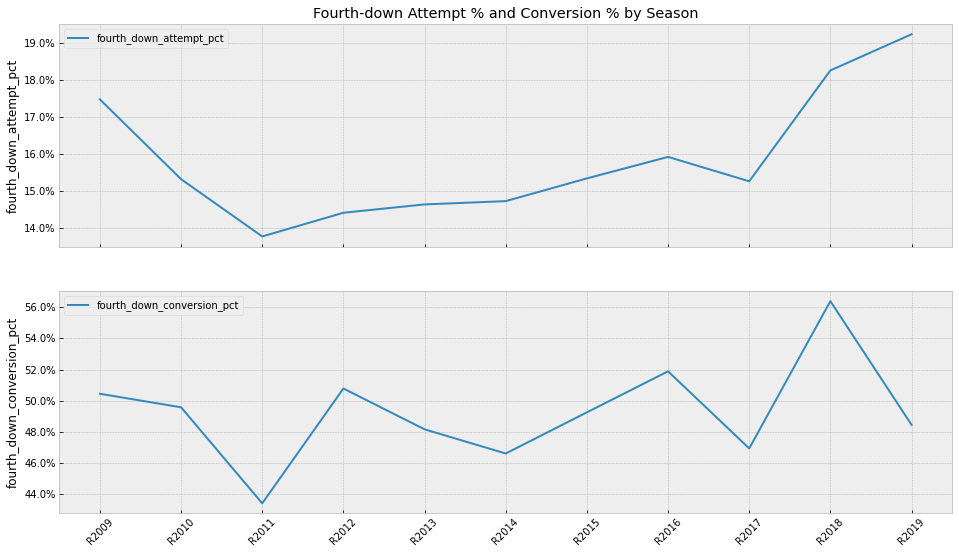

In [13]:
_, axes = plt.subplots(2, 1, figsize=(16, 9), sharex=True)
for ax, col in zip(axes, ["fourth_down_attempt_pct", "fourth_down_conversion_pct"]):

    sns.lineplot(x="season_code", y=col, data=df_season, ax=ax, ci=95, label=col)
    vals = ax.get_yticks()
    _ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
    ax.set_xlabel(None)
    ax.legend()
    plt.xticks(rotation=45)

axes[0].set_title("Fourth-down Attempt % and Conversion % by Season");    

## Fourth-down Attempt % and Conversion % by Week

Interestingly, looking at this by **week in the season**, teams seem to be getting more aggressive going for it on fourth down as the season goes on, but they don’t appear to get any better at converting those attempts throughout the season. 

/var/folders/_p/nf62s7bn6gz_8c8z2tm8bx4h0000gn/T/ipykernel_29073/3588953824.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
/var/folders/_p/nf62s7bn6gz_8c8z2tm8bx4h0000gn/T/ipykernel_29073/3588953824.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


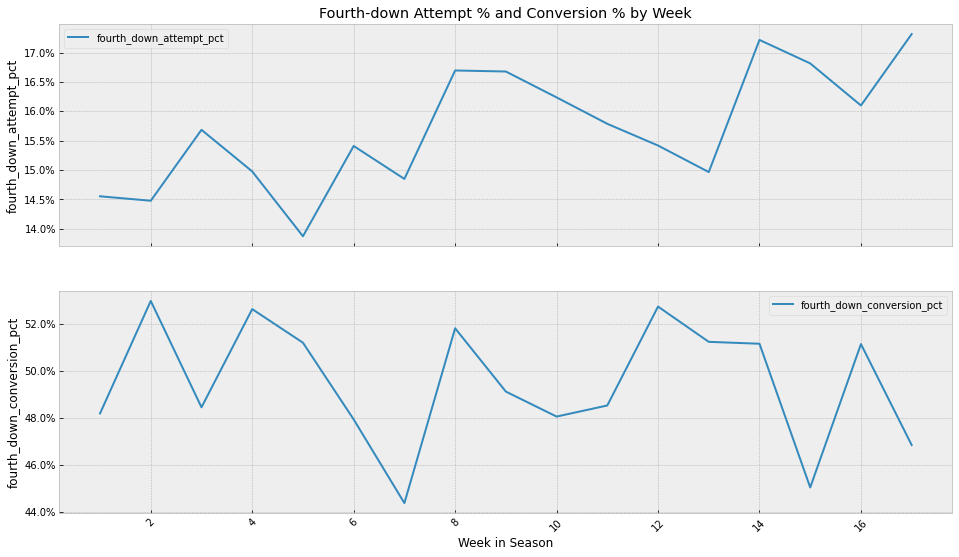

In [14]:
_, axes = plt.subplots(2, 1, figsize=(16, 9), sharex=True)
for ax, col in zip(axes, ["fourth_down_attempt_pct", "fourth_down_conversion_pct"]):
    sns.lineplot(x="season_week", y=col, data=df_week, ax=ax, ci=None, label=col)
    vals = ax.get_yticks()
    _ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
    ax.set_xlabel("Week in Season")
    ax.legend()
    plt.xticks(rotation=45)

axes[0].set_title("Fourth-down Attempt % and Conversion % by Week");        

In [15]:
def metric_heatmap(df, x_col="team_code", y_col="season_code", value_col="fourth_down_attempt_pct", title="", fmt=".0%"):
    
    _, ax = plt.subplots(1, 1, figsize=(16, 16))

    sns.heatmap(
        pd.crosstab(df[x_col], 
                    df[y_col], 
                    values=df[value_col], 
                    aggfunc=np.sum, margins=False),
        cmap="GnBu", fmt=fmt, annot=True, cbar=False,
        ax=ax
    )
    ax.set_ylabel("Team")
    ax.set_xlabel("Regular Season")
    ax.set_title(title)

Looking at a heatmap of fourth down attempt % by **teams vs seasons**, we can possibly spot a couple of trends that we’ll be confirming. For example, we see slightly higher numbers in the last 2 seasons (driven by a few teams such as BAL and ‘NYG). Also, you’ll notice that the Philadelphia Eagles (PHI) have had consistently higher fourth down attempt percentages the last few seasons.

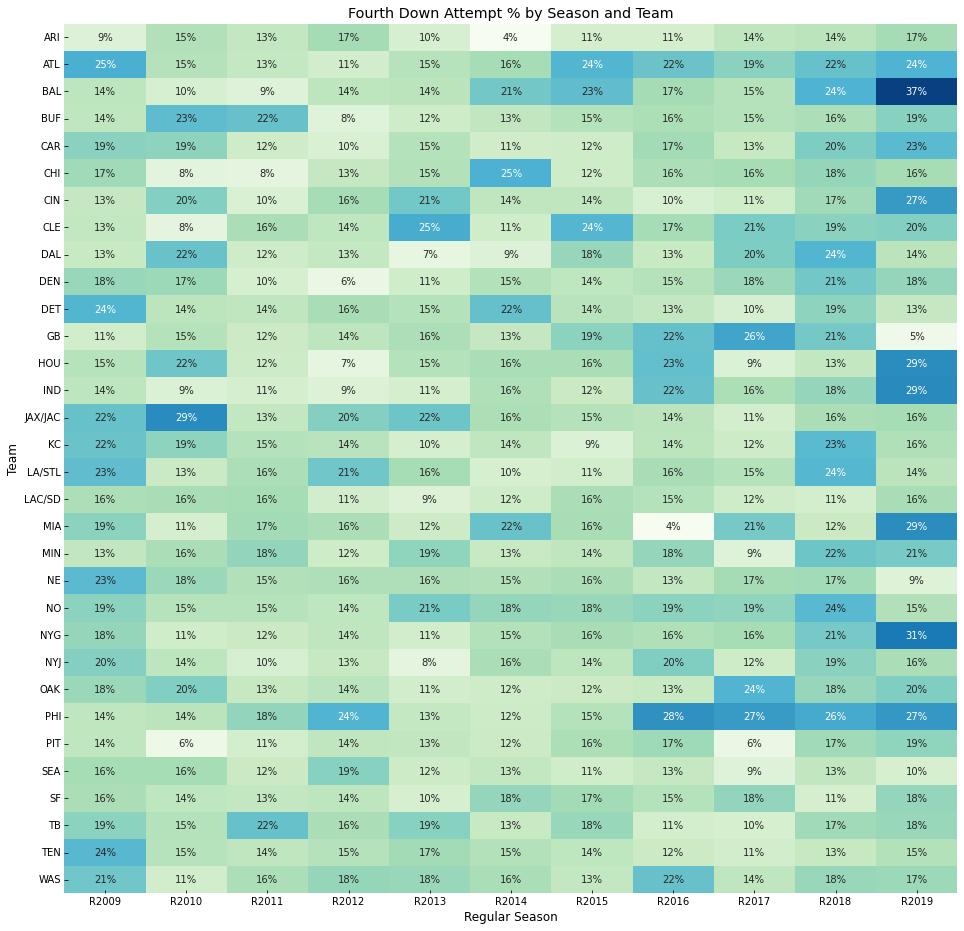

In [16]:
metric_heatmap(df_season_team, value_col="fourth_down_attempt_pct", title="Fourth Down Attempt % by Season and Team")

## Model Data Preprocessing

For the multi-level models, we'll need some indexes to make easier to find the correct group-level parameters. The scikit learn `LabelEncoder` makes that pretty straightforward.

In [17]:
all_teams = pd.Categorical(df_week_team["team_code"])
all_seasons = pd.Categorical(df_week_team["season_code"])
all_weeks = pd.Categorical(df_week_team["season_week"])

In [18]:
le = preprocessing.LabelEncoder()
team_idx = le.fit_transform(df_week_team["team_code"])
n_teams = len(set(team_idx))
season_idx = le.fit_transform(df_week_team["season_code"])
n_seasons = len(set(season_idx))
week_idx = le.fit_transform(df_week_team["season_week"])
n_weeks = len(set(week_idx))

n_teams, n_seasons, n_weeks

(32, 11, 17)

We also need labels for each of our groups

In [19]:
teams = df_week_team["team_code"].unique()
seasons = df_week_team["season_code"].unique()
weeks = df_week_team["season_week"].unique()

In [20]:
teams, seasons, weeks

(array(['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL',
        'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX/JAC', 'KC', 'LA/STL',
        'LAC/SD', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'OAK', 'PHI',
        'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS'], dtype=object),
 array(['R2009', 'R2010', 'R2011', 'R2012', 'R2013', 'R2014', 'R2015',
        'R2016', 'R2017', 'R2018', 'R2019'], dtype=object),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]))

Lastly, we'll get arrays for our observed variables

In [21]:
fourth_down_obs = df_week_team["fourth_downs"].values
attempts_obs = df_week_team["fourth_down_attempts"].values

## Beta-Binomial Model

### Baseline Model

Let's consider to our first question for our dataset: are NFL teams getting more aggressive in "going for it" on fourth down? To try to answer this question, let's think of the **generative process** for fourth down attempts, denoted by $y$. In simple terms, it's a factor of the number of fourth downs a team has over a season, let's use $X$,  and a latent, i.e. unknown, propensity to "go for it", $\theta$

$$y = \theta * X$$

This setup is strikingly similar to a classic coin flip example, where the coin has an unknown bias that we'd like to to estimate. You could easily imagine a coach flipping his lucky coin every time the team faces a fourth down to determine whether to punt or to go for it.

Canonically, coin flip outcomes can be modeled using a *Binomial* distribution, and the process of flipping a coin is often modeling using a *Beta-Binomial* model. In such a model, a *Beta* distribution is used to model the coin's bias (i.e. the latent proportion of heads vs tails) and a *Binomial* distribution is used to model the outcomes of `n` coin flips given this latent bias. 

$$\alpha \sim HalfNormal$$

$$\beta \sim HalfNormal$$

$$\theta \sim Beta(\alpha, \beta)$$

$$y \sim Binomial(n, \theta)$$


As a baseline model, let's set up a simple *Beta-Binomial* model to gauge the latent bias towards "going for it" across *all* seasons, weeks and teams. This is also known as a *pooled* or *fully-pooled* model, since we're combining information across all of our groups. Chris Fonnesbeck wrote a great post, [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/notebooks/multilevel_modeling.html), for the PyMC3 docs that we recommend reading for more on this.


In [22]:
def beta_binomial_model(X_obs, y_obs, **kwargs):
    """
    Simple, non-hierarchical BB model
    """
    with pm.Model() as model:
    
        X_obs_d = pm.Data("X_obs", X_obs)
        y_obs_d = pm.Data("y_obs", y_obs)

        alpha = pm.HalfNormal("alpha", sd=10)
        beta = pm.HalfNormal("beta", sd=10)

        theta = pm.Beta("theta", 
                    alpha=alpha, 
                    beta=beta)
        
        y = pm.Binomial("y", n=X_obs_d, p=theta, observed=y_obs_d)
    
    return model



In [23]:
attempts_base_line_model = beta_binomial_model(fourth_down_obs, attempts_obs, lam=1)
attempts_base_line_model

In [24]:
def render_plate_notation(model, model_name):
    """
    Helper function to render and save PyMC3 models
    in plate notation
    """    
    g = pm.model_to_graphviz(model)
    g.render(model_name, "plots", format="png")

    return g

As you can see, PyMC3 gives us a straightforward way to express the mathematical notation above in Python.

We can also show our model graphically in plate notation:

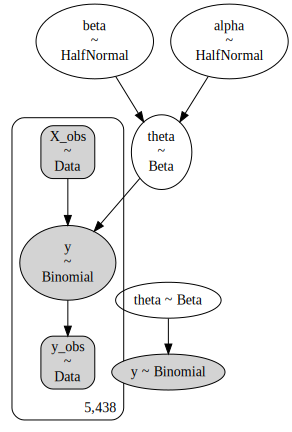

In [25]:
render_plate_notation(attempts_base_line_model, "attempts_base_line_model_graphviz")

A quick overview of this  model:
- The **number of fourth down attempts** `y_obs` are modeled with a $Binomial$ likelihood
- The **number of fourth down tries** are provided as an input, `X_obs` 
- The latent bias/probability of "going for it" on fourth down, `theta` is modeled with a $Beta$ prior, reflecting our knowledge that proportions cannot exceed 100%. Thus, the $Beta$ distribution, bounded by 0 and 1 makes a great candidate as a prior for proportions like this.
This really is our parameter of interest, the posterior distribution of which we'd like to recover through our model. 
- This $Beta$ prior is parameterized with two hyper-priors, `alpha` and `beta`, both modeled using $HalfNormal$ distributions (reflecting the fact that these parameters cannot be negative)


#### Inference

In [26]:
with attempts_base_line_model:
    attempts_base_line_model_inf = pm.sample(**SAMPLE_KWARGS, return_inferencedata=True)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta, beta, alpha]


Sampling 3 chains for 2_000 tune and 4_000 draw iterations (6_000 + 12_000 draws total) took 36 seconds.


After sampling via MCMC/Nuts, we can now take a look at the posteriors of our variables, particularly $theta$.

PyMC3 includes a handy `summary` function that provides us with a few key estimates per variable. 
Aside from `mean` and the range covered in the `hpd` columns, we also want to make sure `r_hat` is ~1, while the effective sample sizes (`ess`) per variable are high enough to explore the posterior tails.

In [27]:
az.summary(attempts_base_line_model_inf)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   3.312  2.039   0.171    6.986      0.028    0.020    4707.0    4343.0   
beta   12.091  6.493   1.060   23.681      0.084    0.059    5358.0    5096.0   
theta   0.157  0.002   0.153    0.161      0.000    0.000    6133.0    6503.0   

       r_hat  
alpha    1.0  
beta     1.0  
theta    1.0

The `arviz.plot_trace` function gives us a quick overview of sampler performance by variable. We're looking for efficient exploration of the posterior space, as shown in the plot below: 


/Users/claus/.pyenv/versions/3.7.4/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/claus/.pyenv/versions/3.7.4/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/claus/.pyenv/versions/3.7.4/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


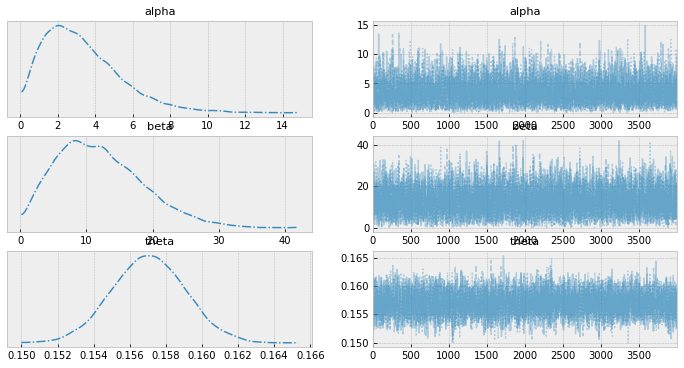

In [28]:
az.plot_trace(attempts_base_line_model_inf, combined=True, compact=True, var_names=["alpha", "beta", "theta"], divergences=None);

Checking Effective Sample Sizes (ESS)

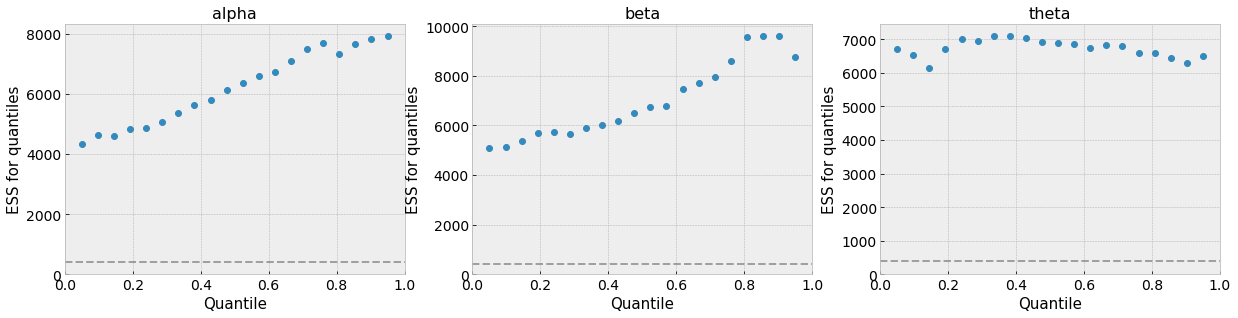

In [29]:
az.plot_ess(attempts_base_line_model_inf, kind="quantile");


#### Posteriors - Baseline Model 

Plotting the posterior for `theta` from our baseline against a reference value (the mean of the observed data), we see that our baseline model estimates that between `15.3%` and `16.1%` of fourth downs result in a fourth down attempt. This is estimated across all seasons, teams and weeks.


In [30]:
attempts_ref_val = df_summary["fourth_down_attempts"].sum()/df_summary["fourth_downs"].sum()

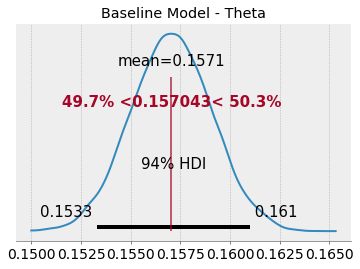

In [31]:
ax = pm.plot_posterior(attempts_base_line_model_inf, 
                  var_names=["theta"],
                  round_to=4,
                  ref_val=attempts_ref_val,
                  
)
ax.set_title("Baseline Model - Theta");

This indicates that our baseline model **doesn't really cover the variability** of this metric from season to season and team to team very well. 2018's average of > 18% for fourth down attempt % isn't even in the 94% HPD (Highest Posterior Density) Interval. Similarly, the Philadelphia Eagles' (`PHI`) fourth down attempt % of `26%` in 2018 would be far out in the tails of this distribution and an outlier in this model.

Thus, while this baseline model converges and samples well, it only models the "average" combination of season, team and week and fails to model the nuances and heterogeneity of our dataset adequately.


### Multi-Level Model

For our next model, an **expansion** of our baseline model, we'll use the same data, but we'll estimate Fourth Down Attempt % by **Season**, which we'll model in a **hierarchical** model. Thus, we will estimate individual posteriors for each season, while also (partially) pooling data across all seasons. 

This ability to *partially* pool data is one of the strengths of Bayesian modeling and allows us to draw strong inferences from small datasets.

The PyMC3 docs have some good insights here, particularly in the application to a similar sports-related problem set, baseball batting averages at https://docs.pymc.io/notebooks/hierarchical_partial_pooling.html:

> We will assume that there exists a hidden factor (phi) related to the expected performance for all players (not limited to our 18). Since the population mean is an unknown value between 0 and 1, it must be bounded from below and above. Also, we assume that nothing is known about global average. Hence, a natural choice for a prior distribution is the uniform distribution.

> Next, we introduce a hyperparameter kappa to account for the variance in the population batting averages, for which we will use a bounded Pareto distribution. This will ensure that the estimated value falls within reasonable bounds. These hyperparameters will be, in turn, used to parameterize a beta distribution, which is ideal for modeling quantities on the unit interval. The beta distribution is typically parameterized via a scale and shape parameter, it may also be parametrized in terms of its mean μ∈[0,1]
and sample size (a proxy for variance) ν=α+β(ν>0)


> The final step is to specify a sampling distribution for the data (hit or miss) for every player, using a Binomial distribution. This is where the data are brought to bear on the model.

> We could use pm.Pareto('kappa', m=1.5), to define our prior on kappa, but the Pareto distribution has very long tails. Exploring these properly is difficult for the sampler, so we use an equivalent but faster parametrization using the exponential distribution. We use the fact that the log of a Pareto distributed random variable follows an exponential distribution.

So, following this example, which supplies us with a good amount of sports-analysis domain knowledge, we’ll also model phi and kappa hyper-priors to partially pool across seasons, and estimate season level theta parameters.

Instead of a Binomial likelihood, we'll use a **Poisson** likelihood, to account for the higher dispersion in fourth down attempts across seasons, teams and weeks.

Thus, we end up with a formulation like this, for each of our models for seasons, teams and weeks.


$$
\begin{array}{l}
\text{phi} \sim Beta(alpha, beta) \\\
\text{kappa_log} \sim Exponential(lam=3.0) \\\
\text{kappa} \sim exp(\text{kappa_log}) \\\
\text{theta} \sim Beta(\alpha=f(\text{phi},~\text{kappa}), \beta=f(\text{phi},~\text{kappa})) \\\
\text{mu} =  X * \text{theta} \\\
y \sim Poisson(\text{mu})
\end{array}
$$

Or, expressed in PyMC3:

In [32]:
def beta_poisson_model_multi(X_obs, y_obs, n_thetas, theta_idx, **kwargs):
    
    with pm.Model() as model:
    
        X_obs_d = pm.Data("X_obs", X_obs)
        y_obs_d = pm.Data("y_obs", y_obs)
        
        # We use a Beta distribution here, 
        # parameterized to be uniform from 0 to 1
        phi = pm.Beta("phi", 1, 1)

        # The rate parameter "lam" lets us control the amount
        # of regularization via our prior, where lower values
        # of "lam" provide stronger regularization 
        # ('rate' here being the inverse of scale)
        kappa_log = pm.Exponential("kappa_log", lam=kwargs.get("lam", 3))
        kappa = pm.Deterministic("kappa", tt.exp(kappa_log))

        theta = pm.Beta("theta", 
                    alpha=phi*kappa, 
                    beta=(1.0-phi)*kappa, 
                    shape=n_thetas)
        
        mu = X_obs_d * theta[theta_idx]
        
        y = pm.Poisson("y", mu=mu, observed=y_obs_d)
    
    return model

In [33]:
attempts_season_model = beta_poisson_model_multi(fourth_down_obs, attempts_obs, len(all_seasons.categories), all_seasons.codes)

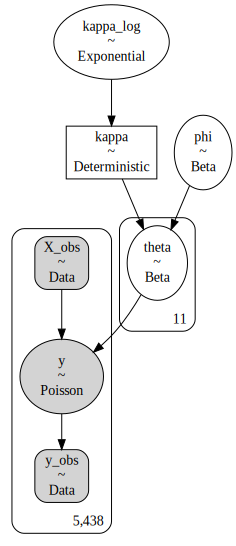

In [34]:
render_plate_notation(attempts_season_model, "attempts_season_model_graphviz")

Moving on this our second model **expansion**. This time, we'll follow the same approach we used for **seasons**, but *pool* our data by **team**.
So, instead of 11 priors for `theta`, we have 32, thus allowing us to estimate posteriors for each team, based on all 11 seasons of weekly team level summary data.

For the team model, we relax the prior a bit via `lam`

In [35]:
attempts_team_model = beta_poisson_model_multi(fourth_down_obs, attempts_obs, len(all_teams.categories), all_teams.codes, lam=5)

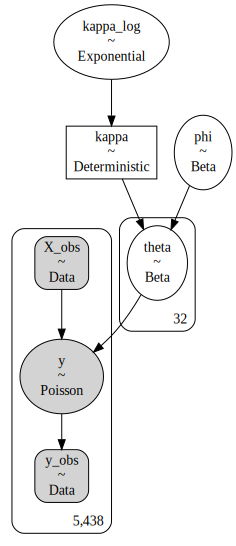

In [36]:
render_plate_notation(attempts_team_model, "attempts_team_model_graphviz")

For our last model expansion, we'll look at whether being earlier or later in the season affects how aggressive teams are on fourth down.

Thus, for this model, we set up 17 priors for `theta`, again partially pooled:

In [37]:
attempts_week_model = beta_poisson_model_multi(fourth_down_obs, attempts_obs, len(all_weeks.categories), all_weeks.codes)

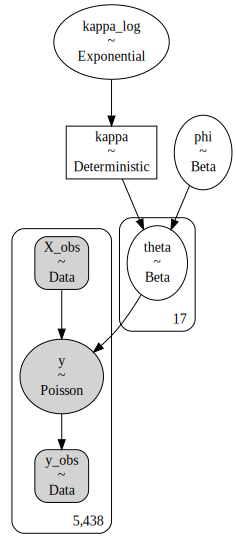

In [38]:
render_plate_notation(attempts_week_model, "attempts_week_model_graphviz")

### Inference

In [39]:
with attempts_season_model:
    attempts_season_trace = pm.sample(**SAMPLE_KWARGS, return_inferencedata=False)
    attempts_season_inf = az.from_pymc3(
        trace=attempts_season_trace,
        coords={"theta_dim_0": all_seasons.categories})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta, kappa_log, phi]


Sampling 3 chains for 2_000 tune and 4_000 draw iterations (6_000 + 12_000 draws total) took 40 seconds.


In [40]:
with attempts_team_model:
    attempts_team_trace = pm.sample(**SAMPLE_KWARGS, return_inferencedata=False)
    attempts_team_inf = az.from_pymc3(
        trace=attempts_team_trace,
        coords={"theta_dim_0": all_teams.categories})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta, kappa_log, phi]


Sampling 3 chains for 2_000 tune and 4_000 draw iterations (6_000 + 12_000 draws total) took 50 seconds.


In [41]:
with attempts_week_model:
    attempts_week_trace = pm.sample(**SAMPLE_KWARGS, return_inferencedata=False)
    attempts_week_inf = az.from_pymc3(
        trace=attempts_week_trace,
        coords={"theta_dim_0": all_weeks.categories})    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta, kappa_log, phi]


Sampling 3 chains for 2_000 tune and 4_000 draw iterations (6_000 + 12_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


### Model Checking

After sampling using MCMC/Nuts, we again check our traces for any signs of misbehaved chains, and spot no issues or divergences. In addition, the effective sample sizes are within usable ranges to sample from the tails of the posterior distributions.

#### Season Model

In [42]:
az.summary(attempts_season_inf, var_names=["theta"]).set_index(all_seasons.categories)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R2009  0.174  0.007   0.160    0.188        0.0      0.0   13856.0    8501.0   
R2010  0.154  0.007   0.141    0.166        0.0      0.0   15697.0    9256.0   
R2011  0.139  0.007   0.127    0.152        0.0      0.0   14221.0    8875.0   
R2012  0.145  0.007   0.132    0.158        0.0      0.0   15382.0    9138.0   
R2013  0.147  0.007   0.135    0.160        0.0      0.0   15697.0    8765.0   
R2014  0.148  0.007   0.135    0.160        0.0      0.0   15373.0    9262.0   
R2015  0.154  0.007   0.141    0.166        0.0      0.0   16391.0    8972.0   
R2016  0.159  0.007   0.146    0.172        0.0      0.0   15154.0    8827.0   
R2017  0.153  0.007   0.140    0.166        0.0      0.0   14373.0    9137.0   
R2018  0.181  0.008   0.166    0.194        0.0      0.0   17573.0    8809.0   
R2019  0.189  0.010   0.171    0.208        0.0      0.0   12709.0    8217.0   

       r_hat  
R2009    1.0  
R2010    1.0  
R2011    1.0  
R2012    1.0  
R2013    1.0  
R2014    1.0  
R2015    1.0  
R2016    1.0  
R2017    1.0  
R2018    1.0  
R2019    1.0

/Users/claus/.pyenv/versions/3.7.4/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/claus/.pyenv/versions/3.7.4/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/claus/.pyenv/versions/3.7.4/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


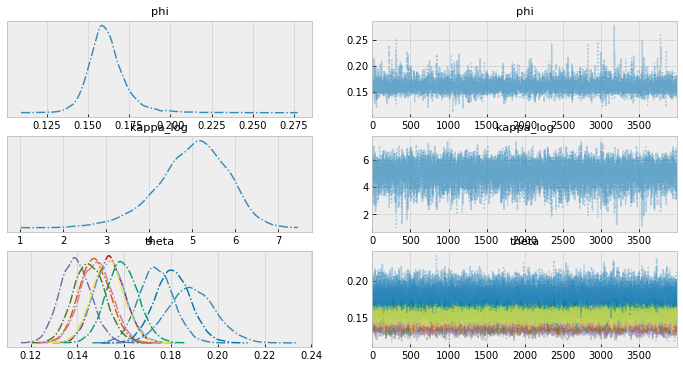

In [43]:
az.plot_trace(attempts_season_inf, combined=True, compact=True, var_names=["phi", "kappa_log", "theta"], divergences=None);

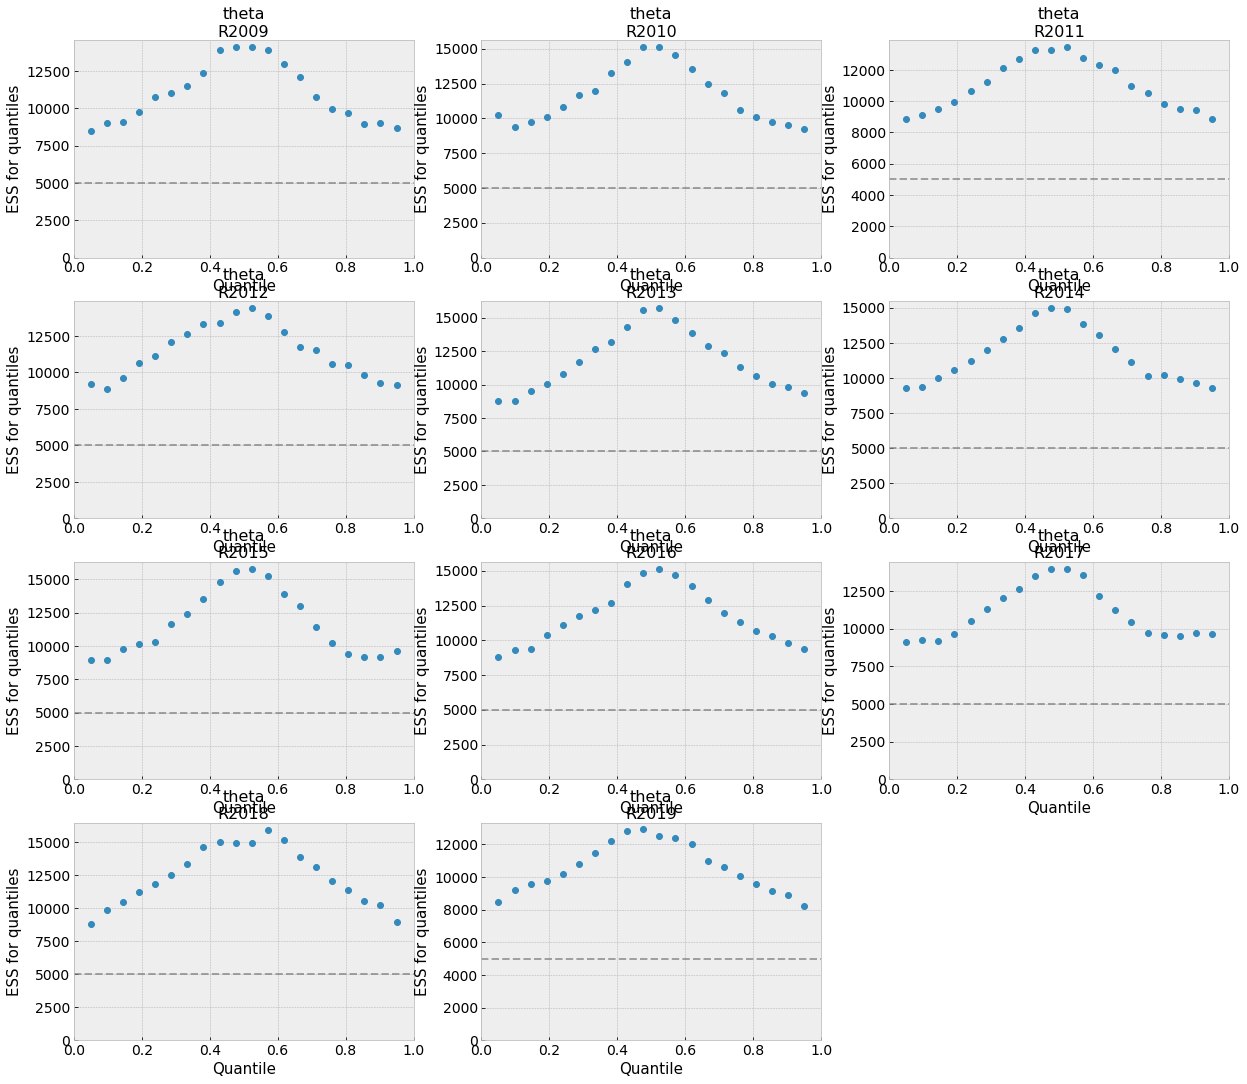

In [44]:
az.plot_ess(attempts_season_inf, kind="quantile", min_ess=5000, var_names=["theta"]);

#### Team Model

In [45]:
az.summary(attempts_team_inf, var_names=["theta"]).set_index(all_teams.categories)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
ARI      0.135  0.010   0.117    0.153        0.0      0.0   18978.0   
ATL      0.174  0.011   0.154    0.196        0.0      0.0   19759.0   
BAL      0.165  0.010   0.145    0.184        0.0      0.0   24704.0   
BUF      0.157  0.010   0.138    0.175        0.0      0.0   26096.0   
CAR      0.156  0.010   0.138    0.175        0.0      0.0   26481.0   
CHI      0.152  0.010   0.135    0.171        0.0      0.0   27402.0   
CIN      0.155  0.010   0.137    0.174        0.0      0.0   26580.0   
CLE      0.166  0.010   0.149    0.185        0.0      0.0   23837.0   
DAL      0.155  0.010   0.136    0.175        0.0      0.0   25393.0   
DEN      0.153  0.010   0.135    0.171        0.0      0.0   24777.0   
DET      0.160  0.010   0.142    0.179        0.0      0.0   23660.0   
GB       0.163  0.010   0.143    0.182        0.0      0.0   27860.0   
HOU      0.156  0.010   0.137    0.174        0.0      0.0   24563.0   
IND      0.149  0.010   0.130    0.168        0.0      0.0   22525.0   
JAX/JAC  0.169  0.010   0.150    0.188        0.0      0.0   24058.0   
KC       0.156  0.010   0.137    0.174        0.0      0.0   24355.0   
LA/STL   0.161  0.010   0.142    0.180        0.0      0.0   25122.0   
LAC/SD   0.144  0.010   0.124    0.163        0.0      0.0   21913.0   
MIA      0.159  0.010   0.140    0.178        0.0      0.0   28202.0   
MIN      0.158  0.010   0.139    0.177        0.0      0.0   26059.0   
NE       0.159  0.010   0.140    0.179        0.0      0.0   28090.0   
NO       0.170  0.011   0.147    0.190        0.0      0.0   22609.0   
NYG      0.159  0.010   0.141    0.179        0.0      0.0   26211.0   
NYJ      0.150  0.010   0.132    0.168        0.0      0.0   27172.0   
OAK      0.156  0.010   0.137    0.173        0.0      0.0   27577.0   
PHI      0.182  0.011   0.160    0.203        0.0      0.0   17974.0   
PIT      0.141  0.010   0.121    0.160        0.0      0.0   19340.0   
SEA      0.143  0.010   0.125    0.162        0.0      0.0   21848.0   
SF       0.152  0.010   0.134    0.170        0.0      0.0   24023.0   
TB       0.162  0.010   0.142    0.181        0.0      0.0   27880.0   
TEN      0.152  0.010   0.134    0.170        0.0      0.0   24378.0   
WAS      0.163  0.010   0.144    0.181        0.0      0.0   23217.0   

         ess_tail  r_hat  
ARI        9335.0    1.0  
ATL        9428.0    1.0  
BAL        7787.0    1.0  
BUF        8012.0    1.0  
CAR        8286.0    1.0  
CHI        8911.0    1.0  
CIN        8661.0    1.0  
CLE        8334.0    1.0  
DAL        8686.0    1.0  
DEN        8990.0    1.0  
DET        8752.0    1.0  
GB         8188.0    1.0  
HOU        8607.0    1.0  
IND        8261.0    1.0  
JAX/JAC    8617.0    1.0  
KC         8605.0    1.0  
LA/STL     8683.0    1.0  
LAC/SD     8486.0    1.0  
MIA        8366.0    1.0  
MIN        8870.0    1.0  
NE         8781.0    1.0  
NO         8435.0    1.0  
NYG        8139.0    1.0  
NYJ        9308.0    1.0  
OAK        8318.0    1.0  
PHI        9074.0    1.0  
PIT        9066.0    1.0  
SEA        9214.0    1.0  
SF         8938.0    1.0  
TB         9261.0    1.0  
TEN        8909.0    1.0  
WAS        9136.0    1.0

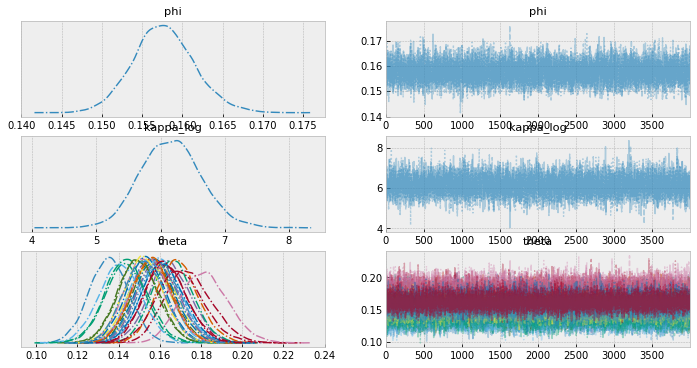

In [46]:
az.plot_trace(attempts_team_inf, combined=True, compact=True, var_names=["phi", "kappa_log", "theta"], divergences=None);

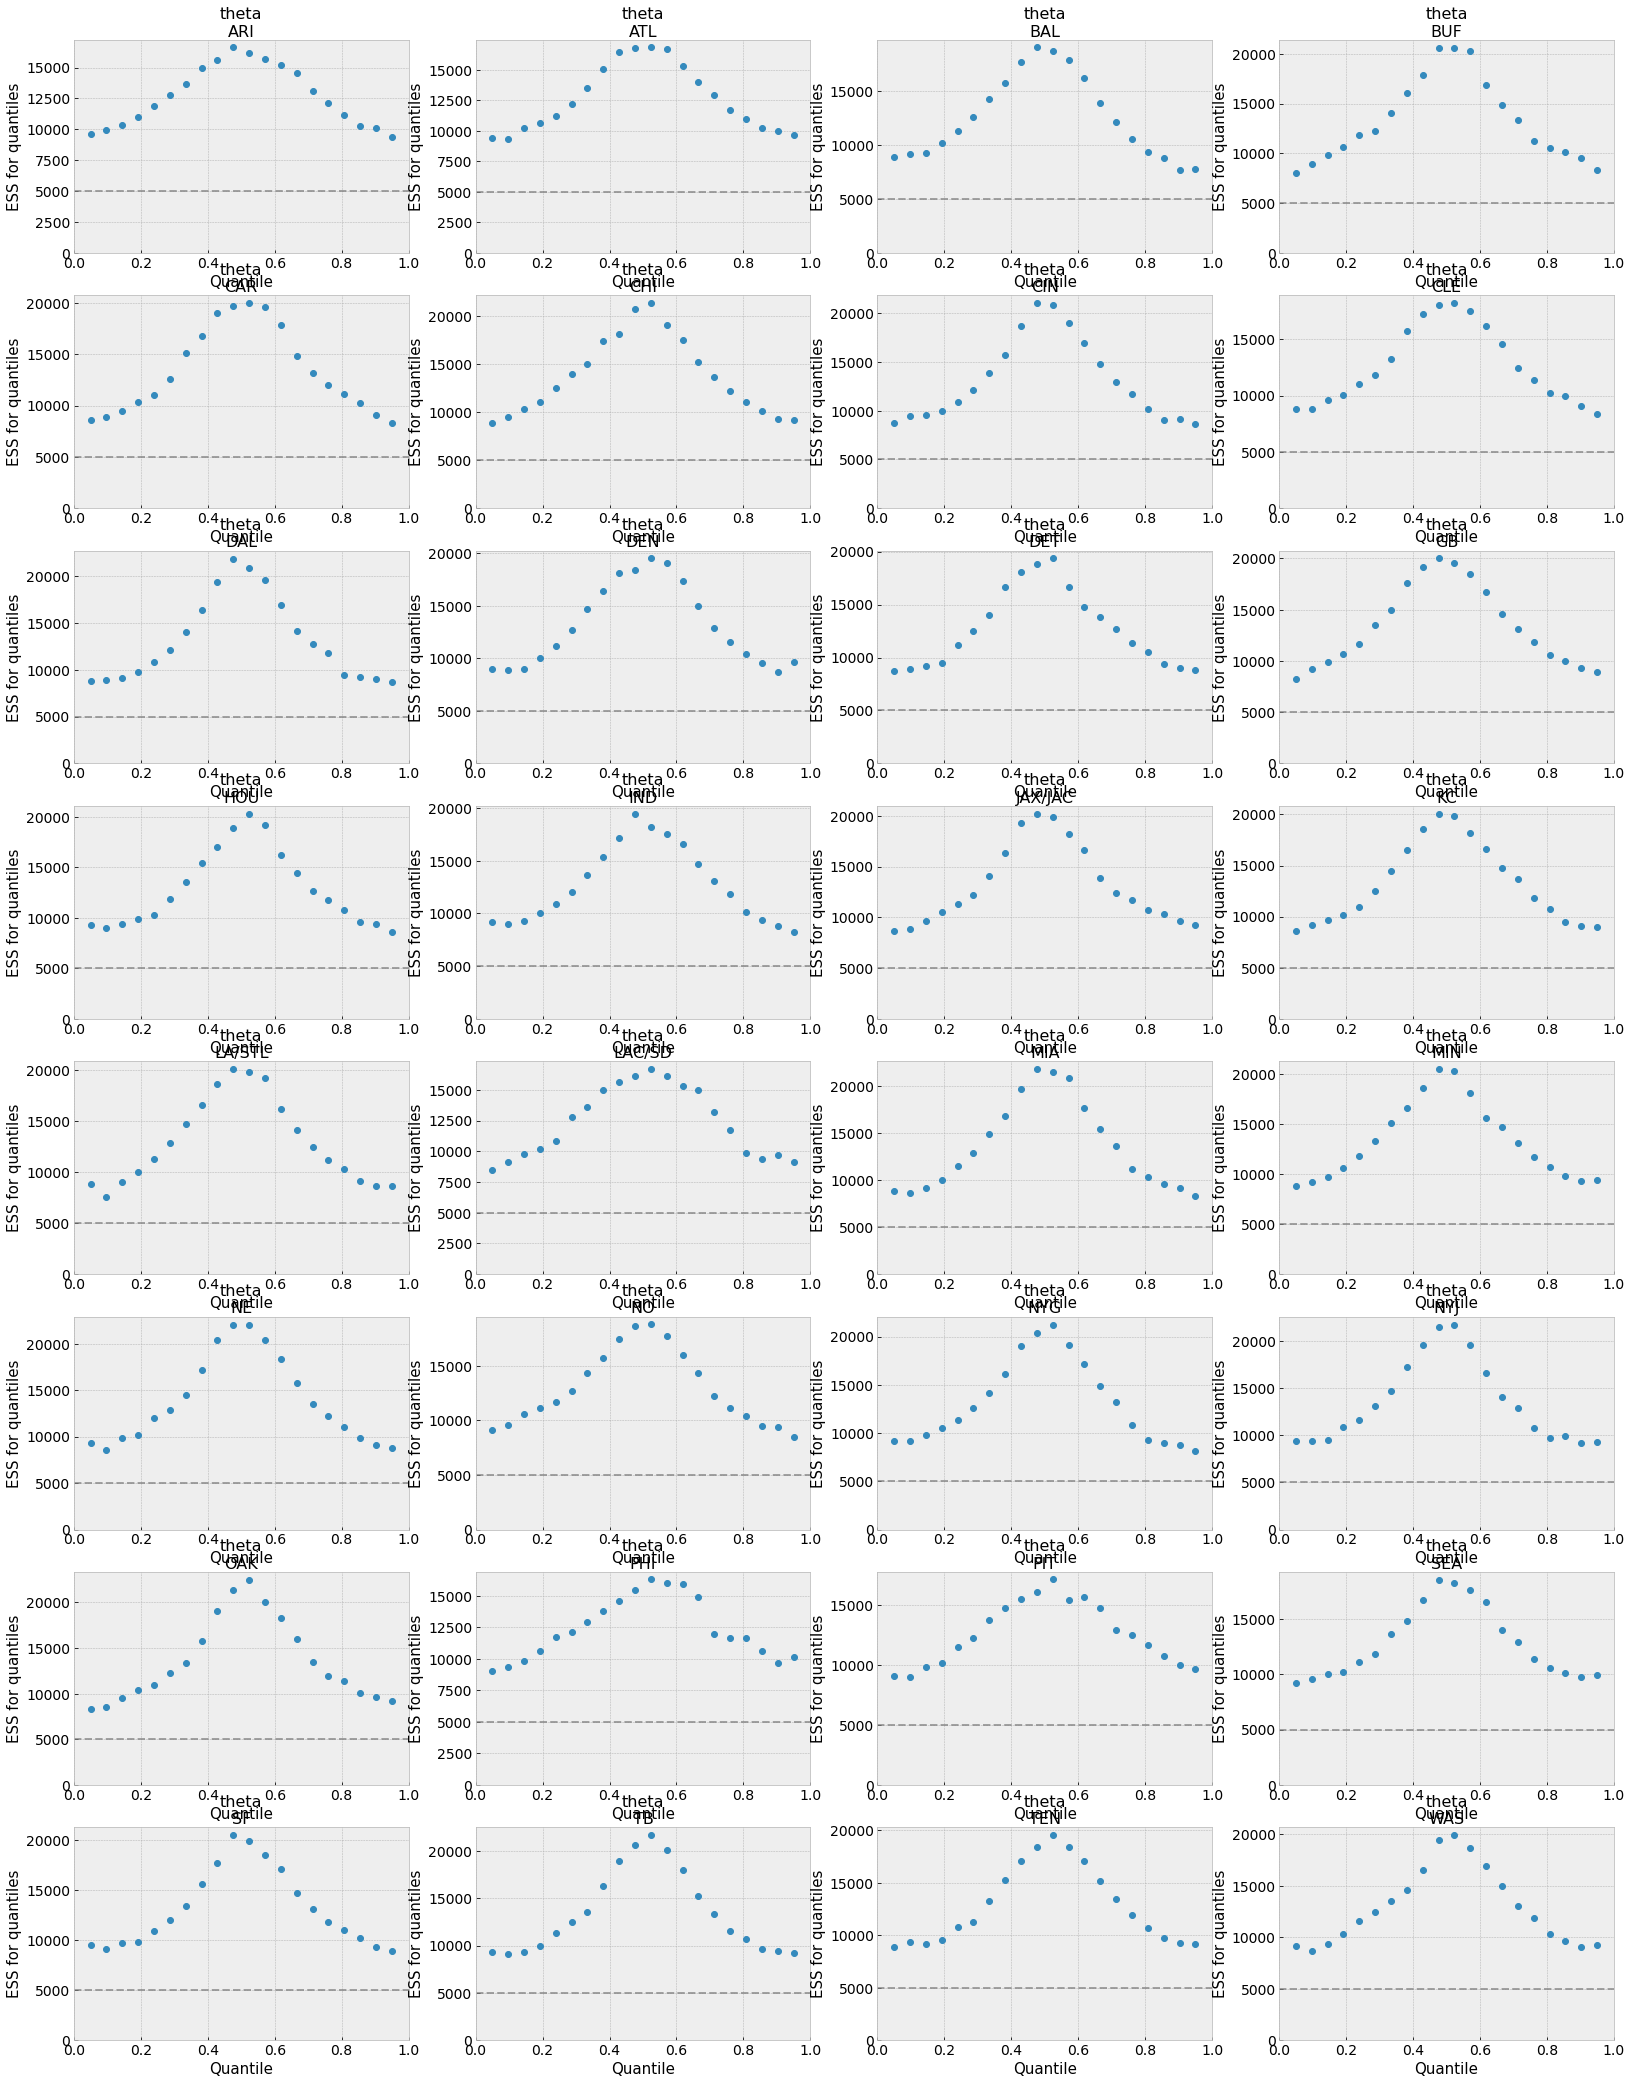

In [47]:
az.plot_ess(attempts_team_inf, kind="quantile", min_ess=5000, var_names=["theta"]);

#### Week Model

In [48]:
az.summary(attempts_week_inf, var_names=["theta"]).set_index(all_weeks.categories)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
1   0.150  0.007   0.137    0.163        0.0      0.0   19762.0    9145.0   
2   0.149  0.007   0.136    0.162        0.0      0.0   19037.0    9421.0   
3   0.157  0.007   0.144    0.171        0.0      0.0   21214.0    9774.0   
4   0.153  0.007   0.139    0.166        0.0      0.0   20357.0    8643.0   
5   0.146  0.008   0.132    0.160        0.0      0.0   15525.0    9856.0   
6   0.155  0.007   0.141    0.170        0.0      0.0   23112.0    8174.0   
7   0.152  0.007   0.138    0.166        0.0      0.0   18990.0    8669.0   
8   0.163  0.008   0.149    0.178        0.0      0.0   19387.0    9009.0   
9   0.163  0.008   0.148    0.178        0.0      0.0   18697.0    8902.0   
10  0.161  0.008   0.146    0.175        0.0      0.0   19953.0    8869.0   
11  0.158  0.007   0.144    0.171        0.0      0.0   21252.0    8955.0   
12  0.155  0.007   0.142    0.169        0.0      0.0   19674.0    8780.0   
13  0.152  0.007   0.139    0.167        0.0      0.0   19500.0    8308.0   
14  0.167  0.008   0.153    0.181        0.0      0.0   18681.0    9333.0   
15  0.164  0.008   0.150    0.178        0.0      0.0   17774.0    9325.0   
16  0.160  0.008   0.146    0.174        0.0      0.0   18929.0    8267.0   
17  0.168  0.008   0.153    0.182        0.0      0.0   15397.0    9056.0   

    r_hat  
1     1.0  
2     1.0  
3     1.0  
4     1.0  
5     1.0  
6     1.0  
7     1.0  
8     1.0  
9     1.0  
10    1.0  
11    1.0  
12    1.0  
13    1.0  
14    1.0  
15    1.0  
16    1.0  
17    1.0

/Users/claus/.pyenv/versions/3.7.4/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/claus/.pyenv/versions/3.7.4/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/claus/.pyenv/versions/3.7.4/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


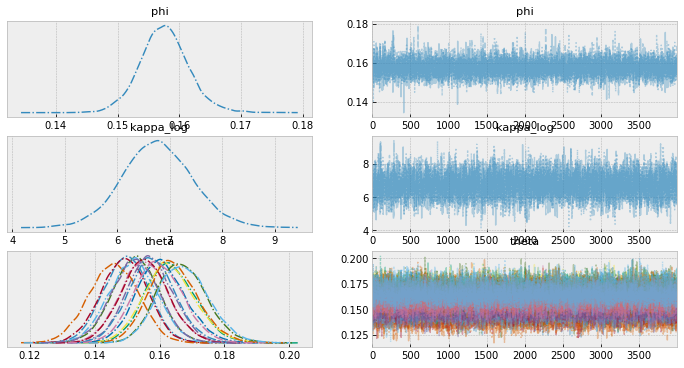

In [49]:
az.plot_trace(attempts_week_inf, combined=True, compact=True, var_names=["phi", "kappa_log", "theta"], divergences=None);

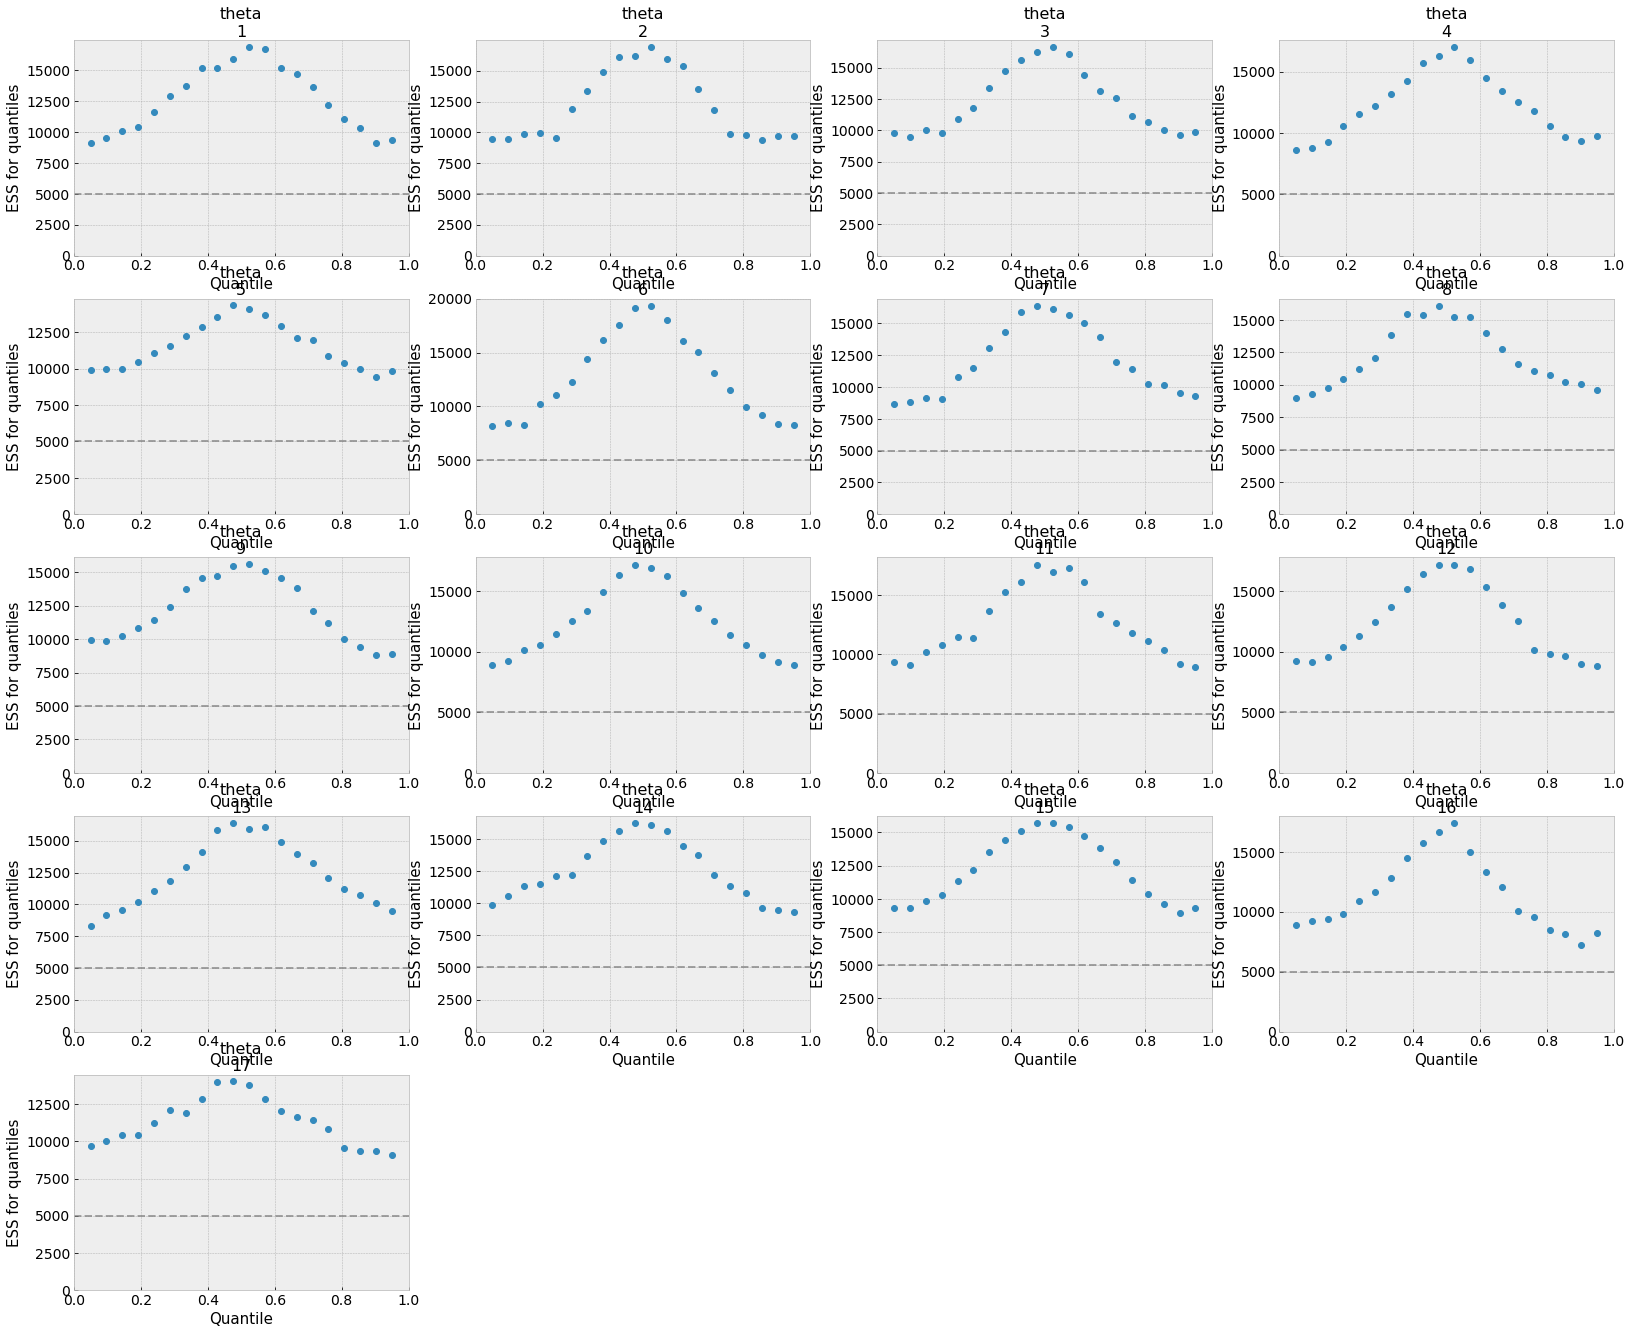

In [50]:
az.plot_ess(attempts_week_inf, kind="quantile", min_ess=5000, var_names=["theta"]);

### Posterior Checks/Critique

Plotting functions:

In [51]:
def plot_forest(data, var, labels, title=None, is_percent=True):
    axes = az.plot_forest(data, kind="forestplot", var_names=[var], combined=True, figsize=(8, int(len(labels)*.4)), colors="cycle");

    if is_percent:
        vals = axes[0].get_xticks()
        _ = axes[0].set_xticklabels(['{:,.1%}'.format(x) for x in vals])
    if title:
        axes[0].set_title(title)

In [52]:
def trace_metrics(data, var_name):
    
    mean = data.posterior[var_name].mean(dim=["chain", "draw"]).values
    hpd = az.hdi(data.posterior[var_name].values) 
    hpd_l, hpd_u = hpd[:, 0], hpd[:, 1]
    return mean, hpd_l, hpd_u

#### Posteriors - Season Model 
Let's take a look at the posterior for `phi`, which we've defined earlier as the parameter that estimates the probability of going for it on fourth down for the "population", i.e. all seasons. 

In [53]:
attempts_season_inf.posterior["theta"].mean(dim=["chain", "draw"]).values

array([0.17372321, 0.15359809, 0.13919655, 0.14515217, 0.1472305 ,
       0.14805912, 0.15375452, 0.15918064, 0.15302838, 0.1808163 ,
       0.18889038])

In [54]:
attempts_season_mean, attempts_season_hpd_l, attempts_season_hpd_u = trace_metrics(attempts_season_inf, "theta")

In [55]:
attempts_ref_val

0.15704303052592866

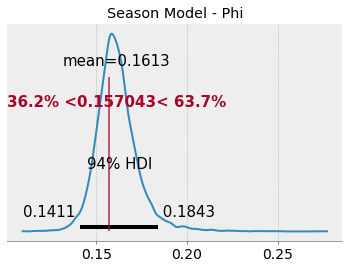

In [56]:
ax = az.plot_posterior(attempts_season_inf, 
                          var_names=["phi"],
                          round_to=4,
                          ref_val=attempts_ref_val
                          )
ax.set_title("Season Model - Phi");

We'll notice that the mean of the posterior for `phi` is slightly higher than our observed mean, and the distribution is long-tailed, capturing the fact that each season may have a much higher value than the average.

Plotting the posteriors for `theta` for each season, we can see how this model nicely captures the range for each season:

/var/folders/_p/nf62s7bn6gz_8c8z2tm8bx4h0000gn/T/ipykernel_29073/4091232277.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes[0].set_xticklabels(['{:,.1%}'.format(x) for x in vals])


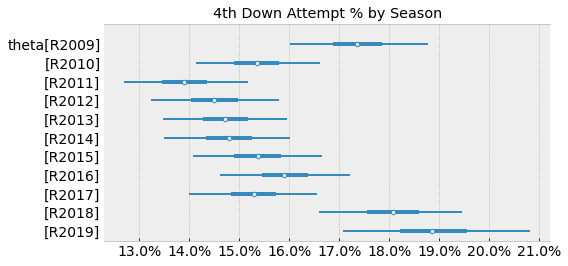

In [57]:
plot_forest(attempts_season_inf, "theta", all_seasons.categories, title="4th Down Attempt % by Season", is_percent=True)

We see that 2018 and 2019 are clearly separated from the prior seasons. However, mid-season it's still maybe too early to tell whether 2019 will indeed break a record for fourth down attempt % in the regular season.

Interestingly, even with stronger **regularization** via our priors, we don't observe a lot of **shrinkage** of estimates towards the mean (an effect/benefit of partial pooling) for those season further away from the group. This is likely a result of strong evidence at the season level overwhelming our priors.

However, we can see *some* evidence of shrinkage visually by plotting our observed season values over the posterior distributions for `theta` by season. We notice that the posterior means for `theta` for both 2018 and 2019 are slightly *lower* than the observed values, while the low observed value for 2011 is below its posterior estimate - this is likely an effect of our model pooling information across seasons and adjusting estimates for those seasons accordingly. 


/var/folders/_p/nf62s7bn6gz_8c8z2tm8bx4h0000gn/T/ipykernel_29073/1615964708.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


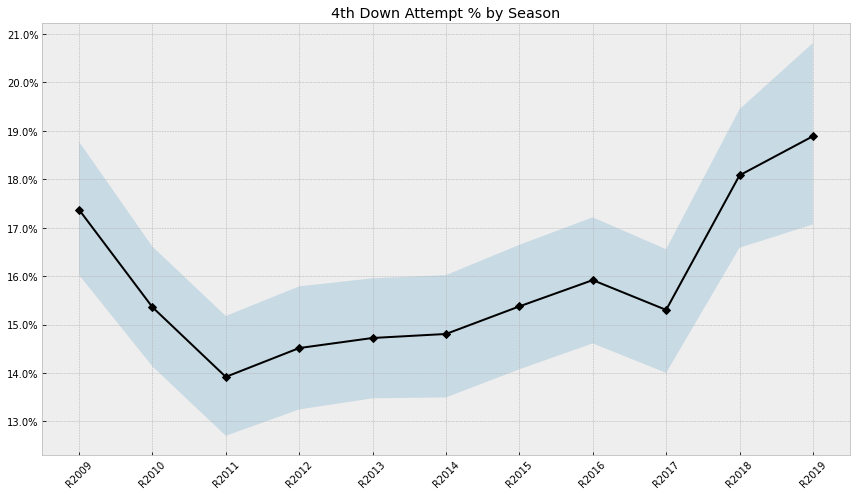

In [58]:
_, ax = plt.subplots(1,1,figsize=(12, 7))
ax.plot(all_seasons.categories, attempts_season_mean, color="k", marker="D")
ax.fill_between(all_seasons.categories, attempts_season_hpd_l, attempts_season_hpd_u, alpha=.2)
ax.set_xticks(all_seasons.categories)
_ = ax.set_xticklabels(all_seasons.categories, rotation=45)
vals = ax.get_yticks()
_ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
ax.set_xlabel(None)
ax.set_title("4th Down Attempt % by Season")
plt.tight_layout();

In [59]:
attempts_season_ref_vals = list(df_season["fourth_down_attempt_pct"].values)

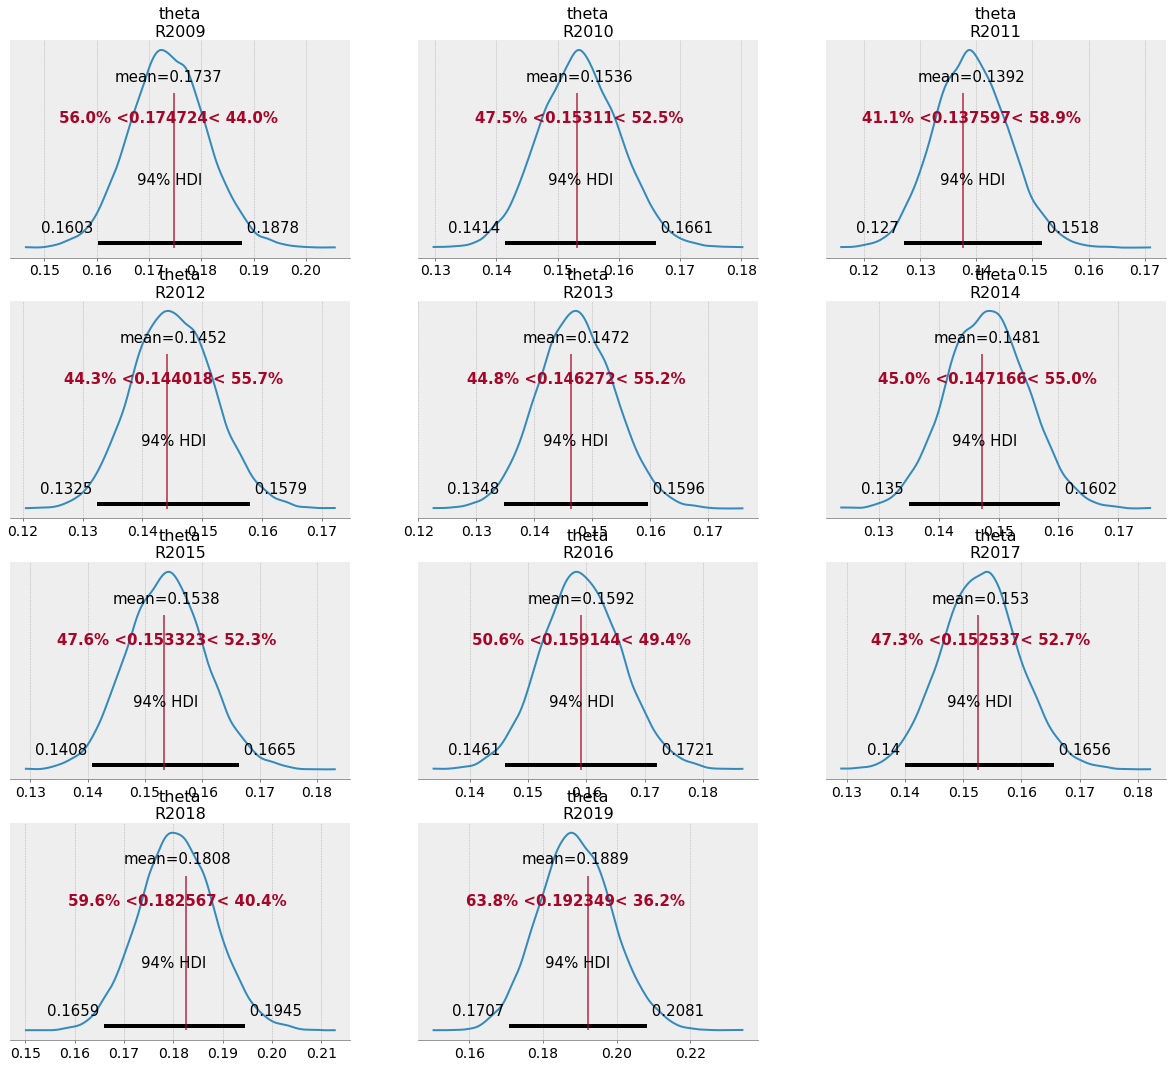

In [60]:
axes = az.plot_posterior(attempts_season_inf, 
                          var_names=["theta"],
                          round_to=4,
                          ref_val=attempts_season_ref_vals
                        ) 

#### Posteriors - Team Model

In this model, `phi` represents the population mean across teams, and we see that there is a lot less variability across teams on fourth down attempts than we saw in the baseline or season models: 

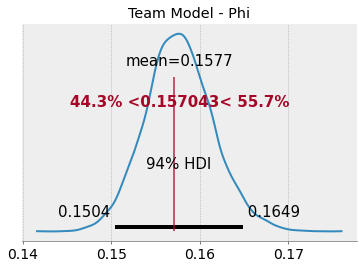

In [61]:
ax = pm.plot_posterior(attempts_team_inf, 
                  var_names=["phi"],
                  round_to=4,
                  ref_val=attempts_ref_val)
ax.set_title("Team Model - Phi");

The `forestplot` of `theta` by team shows that aside from a few teams, most notably the Arizona Cardinals (`ARI`) and the Philadelphia Eagles (`PHI`), most teams hover around the 15.7% group mean:

/var/folders/_p/nf62s7bn6gz_8c8z2tm8bx4h0000gn/T/ipykernel_29073/4091232277.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes[0].set_xticklabels(['{:,.1%}'.format(x) for x in vals])


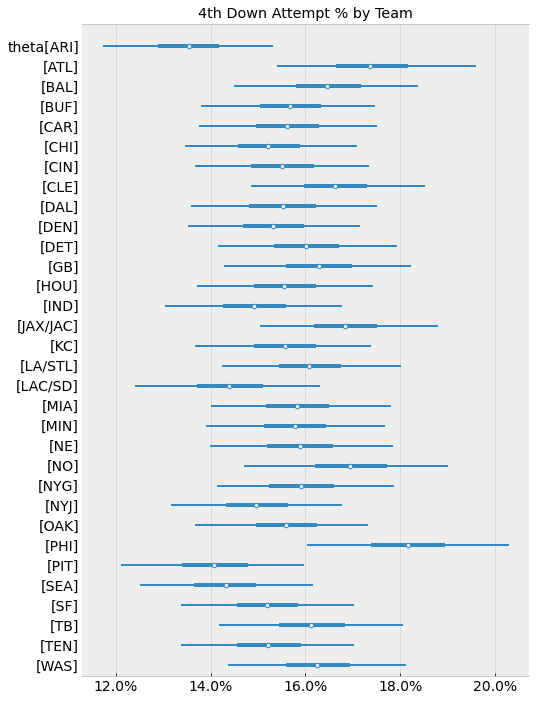

In [62]:
plot_forest(attempts_team_inf, "theta", teams, "4th Down Attempt % by Team");

Again, even experimenting with stronger **regularization** via our priors, we don't observe a lot of **shrinkage** of estimates towards the mean for those teams further away from the group, but we do note it for the stronger and weaker teams:

In [63]:
attempts_team_ref_vals = list(df_team["fourth_down_attempt_pct"].values)

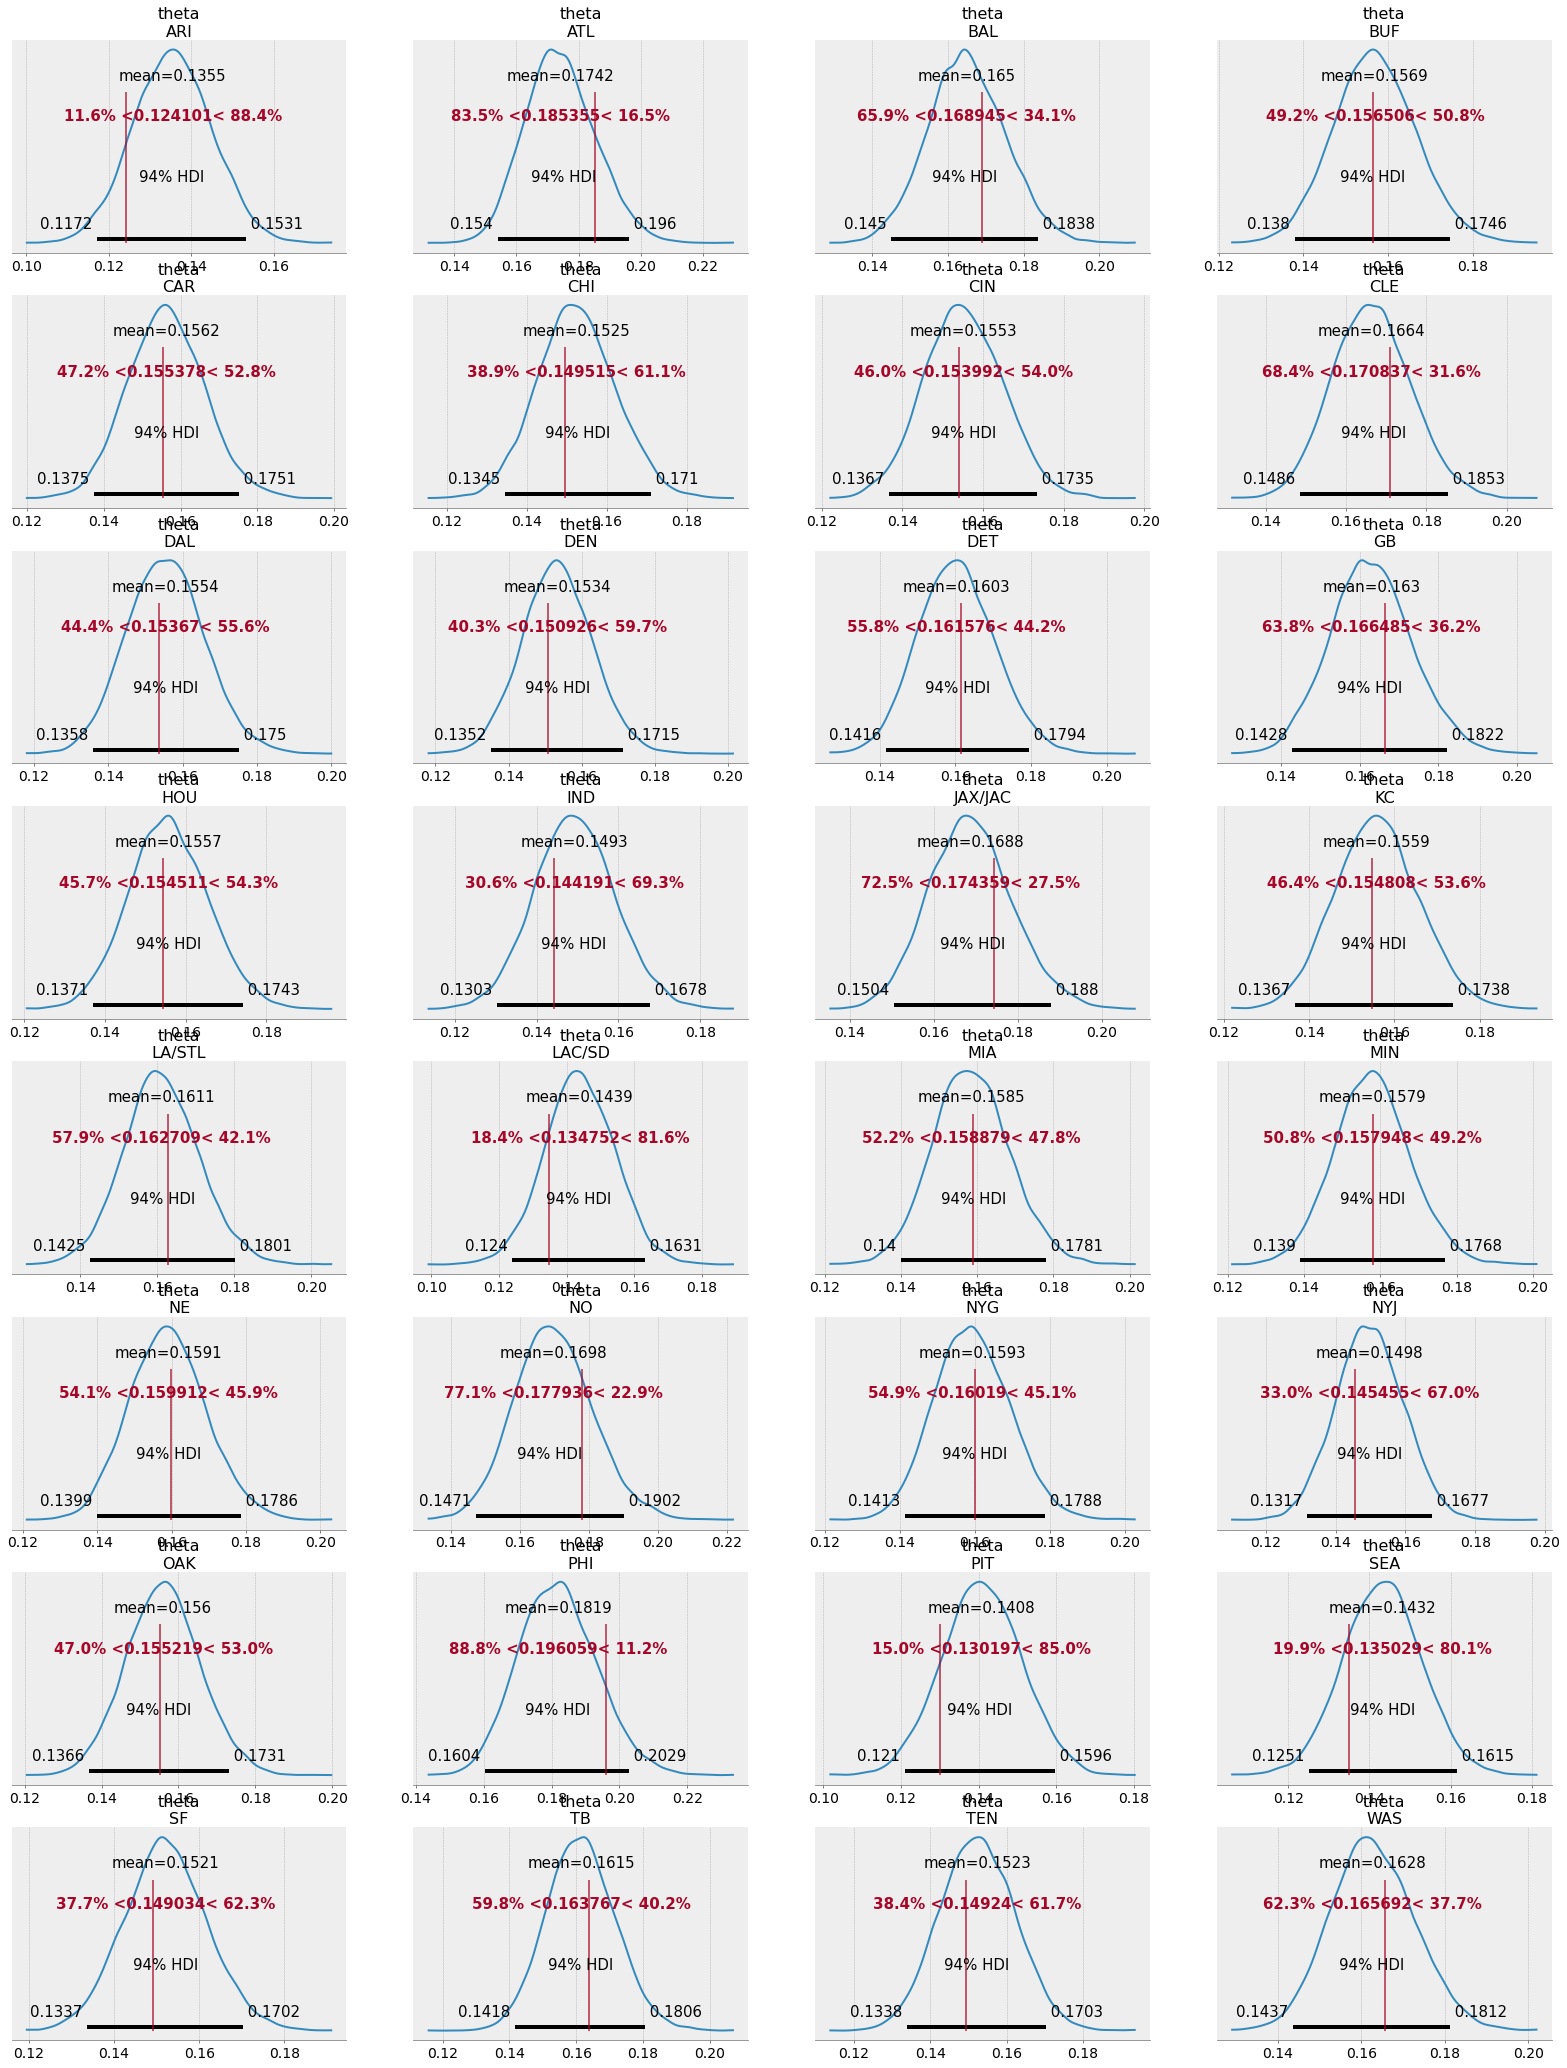

In [64]:
axes = az.plot_posterior(attempts_team_inf, 
                  var_names=["theta"], 
                  round_to=4,
                  ref_val=attempts_team_ref_vals)

#### Posteriors - Week Model
The group mean, estimated via `phi` looks even more cohesive than previous model, suggesting lower variability from week to week. 

In [65]:
attempts_week_mean, attempts_week_hpd_l, attempts_week_hpd_u = trace_metrics(attempts_week_inf, "theta")

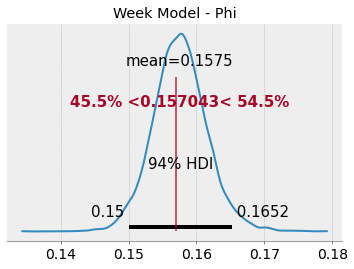

In [66]:
ax = pm.plot_posterior(attempts_week_inf, 
                  var_names=["phi"],
                  round_to=4,
                  ref_val=attempts_ref_val)
ax.set_title("Week Model - Phi");

However, looking at `theta` by week, we can spot a slight upward trend from early weeks to week later in the regular season:

/var/folders/_p/nf62s7bn6gz_8c8z2tm8bx4h0000gn/T/ipykernel_29073/4091232277.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes[0].set_xticklabels(['{:,.1%}'.format(x) for x in vals])


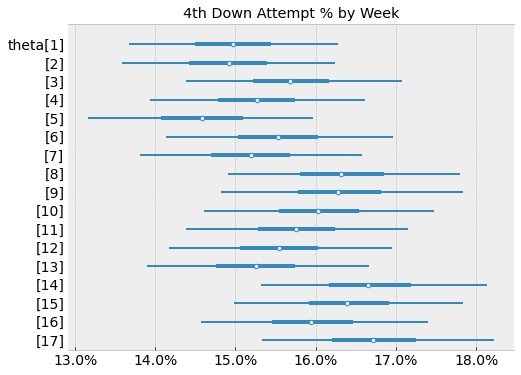

In [67]:
plot_forest(attempts_week_inf, "theta", weeks, "4th Down Attempt % by Week");

/var/folders/_p/nf62s7bn6gz_8c8z2tm8bx4h0000gn/T/ipykernel_29073/3922526035.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


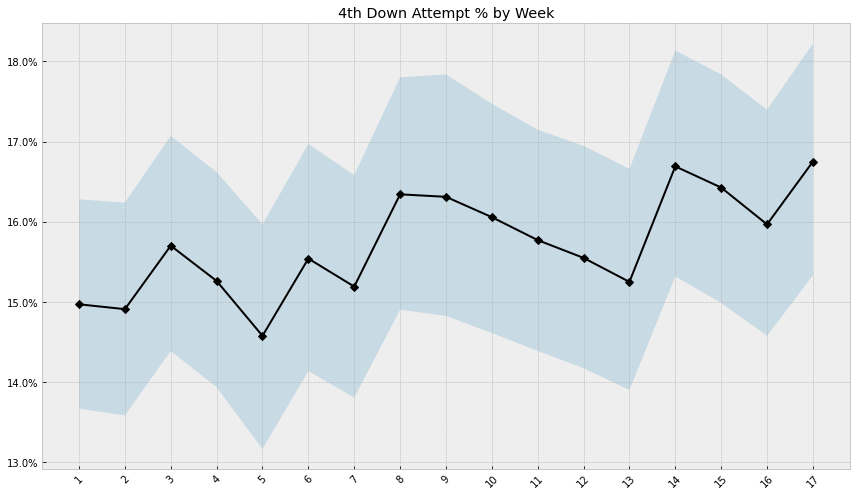

In [68]:
_, ax = plt.subplots(1,1,figsize=(12, 7))
ax.plot(all_weeks.categories, attempts_week_mean, color="k", marker="D")
ax.fill_between(all_weeks.categories, attempts_week_hpd_l, attempts_week_hpd_u, alpha=.2)
ax.set_xticks(all_weeks.categories)
_ = ax.set_xticklabels(all_weeks.categories, rotation=45)
vals = ax.get_yticks()
_ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
ax.set_xlabel(None)
ax.set_title("4th Down Attempt % by Week")
plt.tight_layout();

In this model, we can visually observe more shrinkage, particularly for weeks 5, 14, 15, and 17. This gives us some confidence that an unpooled model, or non-Bayesian approach, would have likely under/overestimated the latent fourth down attempt %.


In [69]:
attempts_week_ref_vals = list(df_week["fourth_down_attempt_pct"].values)

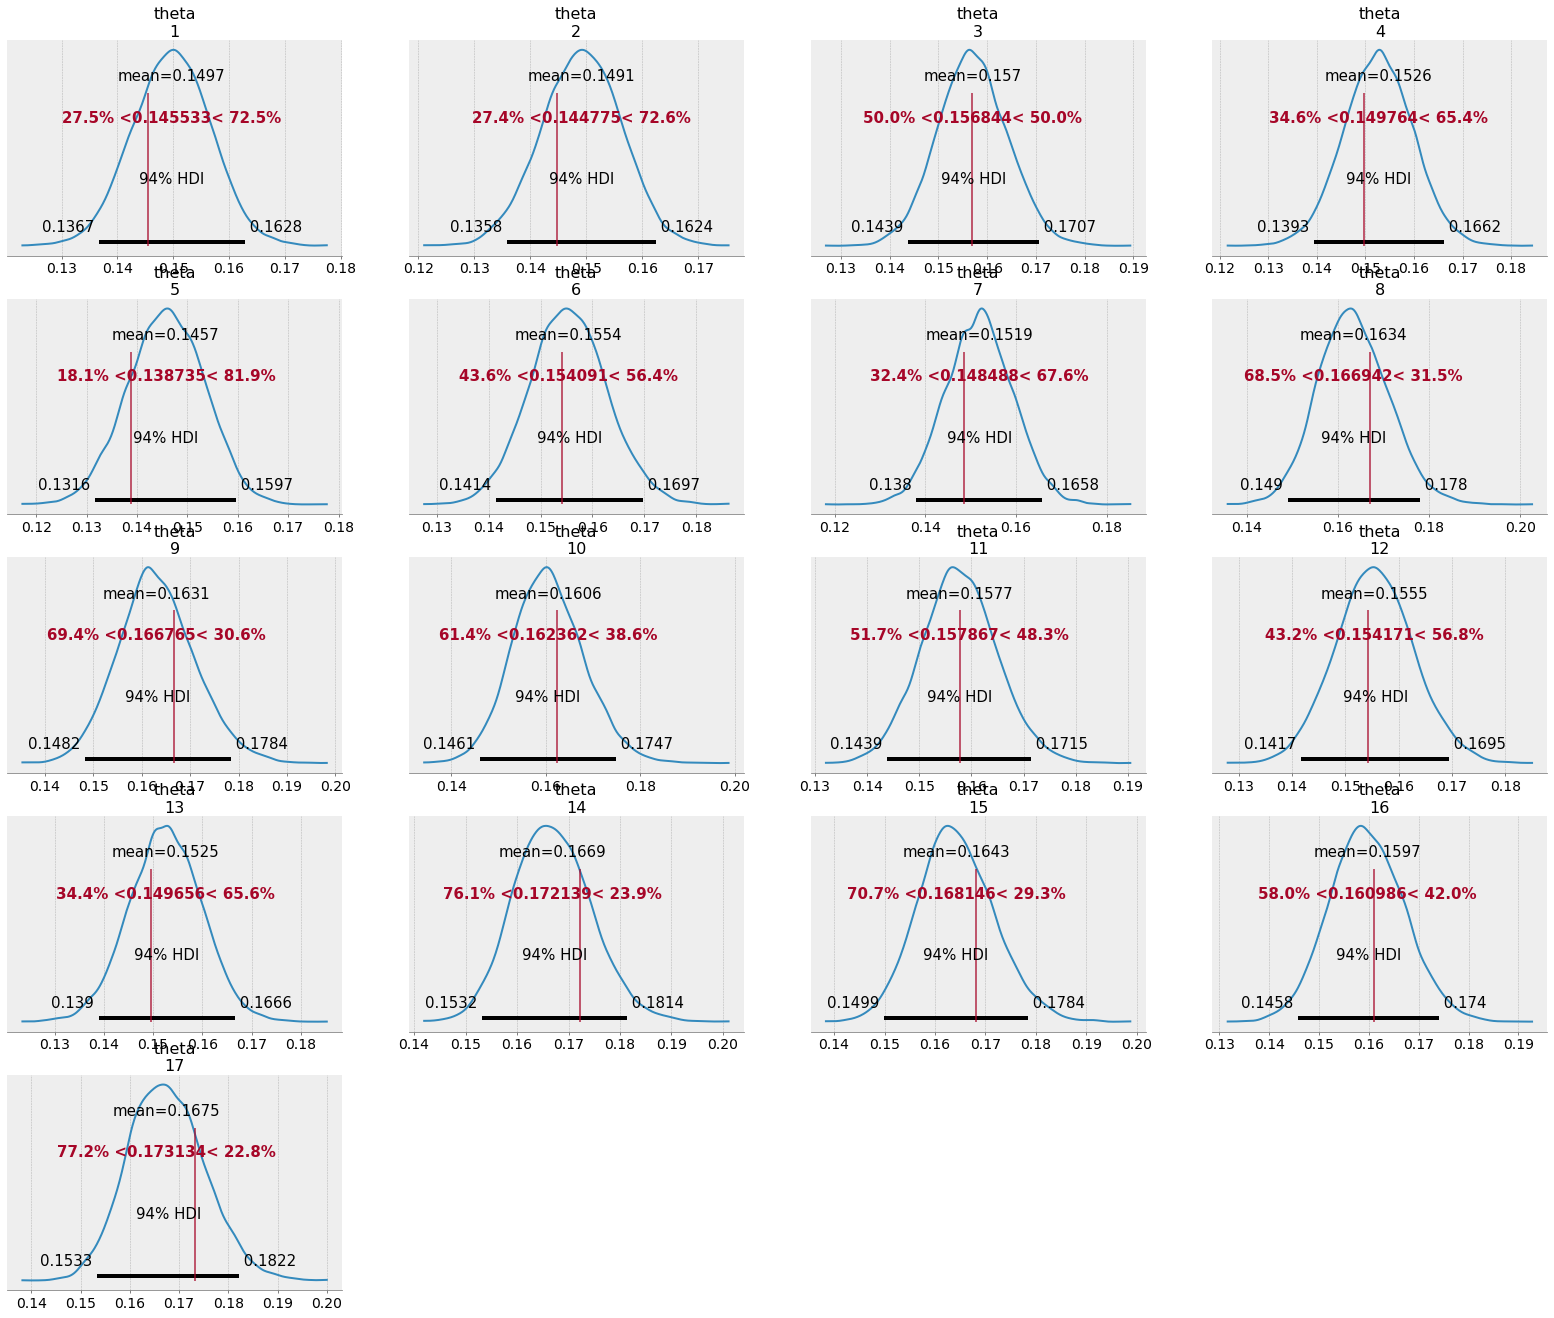

In [70]:
axes = az.plot_posterior(attempts_week_inf, 
                  var_names=["theta"],
                  round_to=4,
                  ref_val=attempts_week_ref_vals)

### Model Comparison
While we've learned a lot about our data, and Bayesian model by building 4 separate models (from the same dataset, modeling the same outcome variable), we may have to pick one of the models. For example, if we wanted to predict fourth down attempts, we want to chose the model that best captures our data generating process.

In Bayesian modeling, there are a number of techniques and metrics to quantify model performance and to compare models.

PyMC3 and Arviz have some of the most effective approaches built in.
For example, the atply named "Widely Applicable Information Criterion", or WAIC, is a method for
>estimating pointwise out-of-sample prediction accuracy from a fitted Bayesian model using the log-likelihood evaluated at the posterior simulations of the parameter values.

Lower values of WAIC are better, thus, for predictive accuracy, we would favor our **season** model:


In [71]:
compare_dict = {"Attempts/[Baseline]": attempts_base_line_model_inf, 
                "Attempts/Season": attempts_season_inf, 
                "Attempts/Team": attempts_team_inf,
                "Attempts/Week": attempts_week_inf,
               }
df_compare = az.compare(compare_dict, ic="waic", scale="deviance")
df_compare

rank          waic     p_waic     d_waic    weight  \
Attempts/Season         0  13144.938125   9.839381   0.000000  0.664421   
Attempts/Team           1  13175.151773  19.974037  30.213649  0.074709   
Attempts/Week           2  13177.092033  10.972981  32.153908  0.000000   
Attempts/[Baseline]     3  13202.076113   1.161060  57.137988  0.260870   

                             se        dse  warning waic_scale  
Attempts/Season       99.424517   0.000000    False   deviance  
Attempts/Team         98.644347  14.803194    False   deviance  
Attempts/Week         99.319394  13.980765    False   deviance  
Attempts/[Baseline]  107.745356  22.754826    False   deviance

It's also good to see that our baseline model scores the worst of the four, confirming our initial take that the fully pooled model fails to capture our data well.

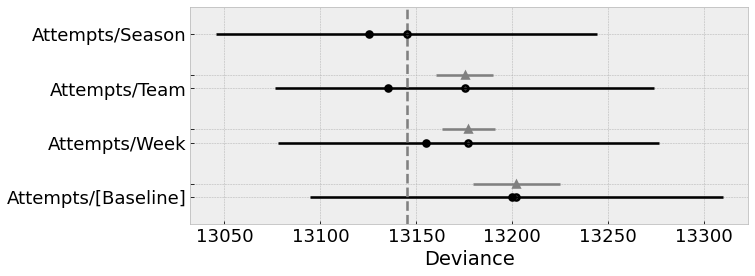

In [72]:
az.plot_compare(df_compare, figsize=(10, 4));

## Weekly Trend Model

To check whether the upward trend we saw in our **weekly** model is quantifiable, let's set up a quick linear model. If there is in fact a positive trend in fourth attempt % as the weeks progress, we should be able to estimate a positive slope/coefficient for *week* as a regressor.

Our model will be:
$Y = \alpha + X\beta + \epsilon$

Where $X$ is a single feature vector made up of only *week*.

In [73]:
with pm.Model() as attempts_week_linear_model:
    
    α = pm.Normal("α", mu=0, sd=1)
    
    β = pm.Normal("β", mu=0, sd=1)
    
    σ = pm.HalfNormal("σ", sd=20)
    μ = α + β * df_week["season_week"]
     
    y_attempt_ratio = pm.Normal("y_attempt_ratio", mu=μ, sd=σ, observed=df_week["fourth_down_attempt_pct"])


This is not a particularly complex model, nor does it need to be. We just want to estimate a simple slope parameter to confirm whether there is a positive relationship between "season_week" and the % of fourth downs attempted.

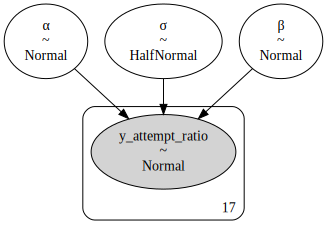

In [74]:
render_plate_notation(attempts_week_linear_model, "attempts_week_linear_model")

In [75]:
attempts_week_linear_model

In [76]:
with attempts_week_linear_model:
    attempts_week_linear_trace = pm.sample(**SAMPLE_KWARGS, return_inferencedata=False)
    attempts_week_linear_ppc = pm.sample_posterior_predictive(attempts_week_linear_trace)

    attempts_week_linear_inf = az.from_pymc3(
        trace=attempts_week_linear_trace,
        posterior_predictive=attempts_week_linear_ppc)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [σ, β, α]


Sampling 3 chains for 2_000 tune and 4_000 draw iterations (6_000 + 12_000 draws total) took 20 seconds.


After sampling with MCMC/Nuts, we get the following parameter estimates, summarized for us by PyMC3:

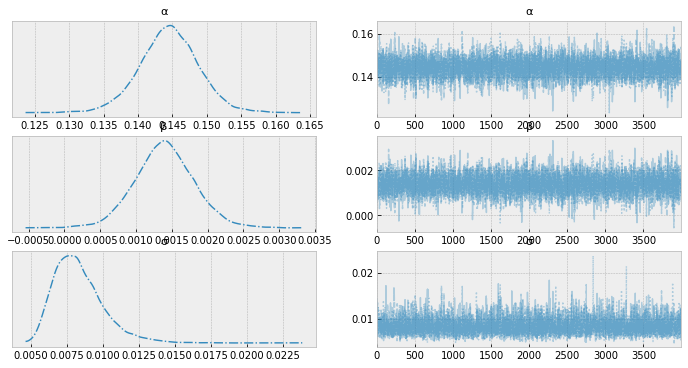

In [77]:
az.plot_trace(attempts_week_linear_inf, combined=True, compact=True, divergences=None);

In [78]:
az.summary(attempts_week_linear_inf, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
α  0.14449  0.00433  0.13650  0.15279    0.00007  0.00005  3947.76512   
β  0.00140  0.00042  0.00063  0.00219    0.00001  0.00000  4069.06914   
σ  0.00833  0.00175  0.00540  0.01149    0.00003  0.00002  4746.85512   

     ess_tail    r_hat  
α  4642.47934  1.00018  
β  4690.77316  1.00025  
σ  5178.29952  1.00079

We'll notice that the posterior for our slope parameter $\beta$, while small is positive across the HPD interval. This implies that there is an average increase of fourth downs attempted of `0.14%` per week, over the baseline average of `14.44%`.

Plotting estimates for mean and HPD interval from our earlier model by *week*, along with the posterior predictive values from this model, we get visual confirmation of the upward trend. It's also a nice check that we get sensible results from both models.

In [79]:
a_m = attempts_week_linear_inf.posterior["α"].mean(dim=["chain", "draw"]).values
b_m = attempts_week_linear_inf.posterior["β"].mean(dim=["chain", "draw"]).values

In [80]:
y_m = attempts_week_linear_inf.posterior_predictive["y_attempt_ratio"].mean(dim=["chain", "draw"]).values
y_hpd = az.hdi(attempts_week_linear_inf.posterior_predictive["y_attempt_ratio"].values)
y_l, y_u = y_hpd[:, 0], y_hpd[:, 1]

/var/folders/_p/nf62s7bn6gz_8c8z2tm8bx4h0000gn/T/ipykernel_29073/4238736838.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


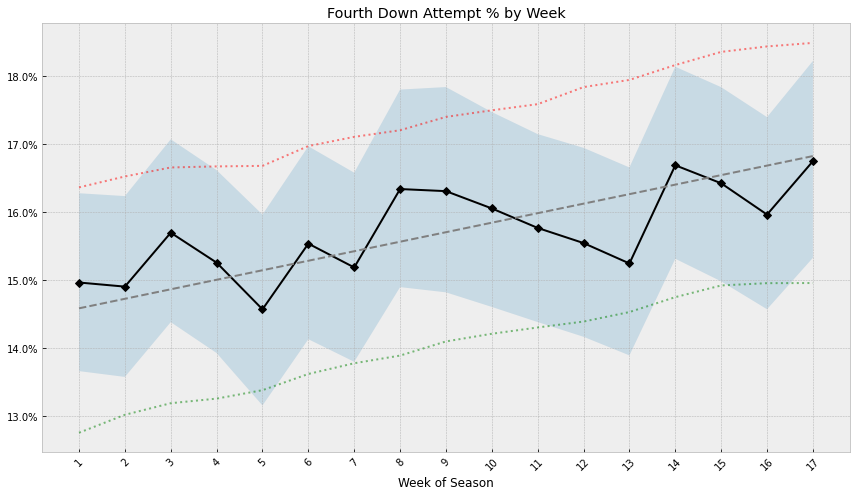

In [81]:
_, ax = plt.subplots(1,1,figsize=(12, 7))
ax.plot(all_weeks.categories, attempts_week_mean, color="k", marker="D")
ax.fill_between(all_weeks.categories, attempts_week_hpd_l, attempts_week_hpd_u, alpha=.2)

ax.plot(weeks, y_l, color="g", linestyle="dotted", alpha=.5)
ax.plot(weeks, a_m + weeks * b_m, color="grey", linestyle="dashed")
ax.plot(weeks, y_u, color="r", linestyle="dotted", alpha=.5)

ax.set_xticks(all_weeks.categories)
_ = ax.set_xticklabels(all_weeks.categories, rotation=45)

vals = ax.get_yticks()
_ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
ax.set_xlabel("Week of Season")
ax.set_title("Fourth Down Attempt % by Week")
plt.tight_layout();